### Prototype functions for eigenfunctions and corresponding eigenvalues
 
The prototype functions takes vector-valued limits of the D-dimensional Cartesian space $\Omega = [-L_1,L_1] \times [-L_2, L_2] \times \ldots \times [-L_D, L_D]$ for a 
$$\text{proto}_\lambda = L \mapsto \left(n \mapsto \sum^D_{i=1}\frac{\pi n_i}{2L_i}\right)$$

$$\text{proto}_\phi = L \mapsto \left(n \mapsto \left(\mathbf{x} \mapsto \prod^D_{i=1}\sqrt{\frac{1}{L}}\sin\left(\frac{\pi n_i (x_i + L_i)}{2L_i}\right)\right)\right) $$

Where $L = [L_1, L_2, \ldots, L_D]^\text{T}$, $n = [n_1, n_2, \ldots, n_D]^\text{T}$, and $\mathbf{x} \in \Omega$

In [1]:
proto_λ = L -> (n -> sum(π*n./(2L)))
proto_ϕ = L -> (n -> (x -> prod(sqrt.(1./L).*sin.(π*n.*(x + L)./(2L)))))

(::#5) (generic function with 1 method)

## 2-dimensional output
$L = [1, 1]^\text{T}$

In [2]:
L = [1.;1.]
λ, ϕ = proto_λ(L), proto_ϕ(L)

(#2, #6)

In [3]:
N = 100
𝐧 = [[nᵢ;nⱼ] for nᵢ ∈ 1:10 for nⱼ ∈ 1:10]

λᵥ = map(λ, 𝐧)
            
ix = sortperm(λᵥ)
𝐧  = 𝐧[ix[1:N]]
; # suppress output

In [4]:
nₓ = 200

𝑥,𝑦 = linspace(-L[1], L[1], nₓ), linspace(-L[2], L[2], nₓ)

𝐱 = [[xᵢ;xⱼ] for xᵢ ∈ 𝑥 for xⱼ ∈ 𝑦]

fₙ = map(n -> map(ϕ(n), 𝐱), 𝐧)
; #supress output

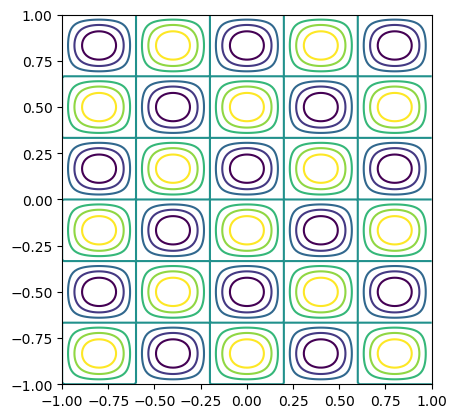

(-1.0, 1.0, -1.0, 1.0)

In [5]:
using PyPlot

contour(𝑥, 𝑦, reshape(fₙ[50], nₓ, nₓ))
axis(:square)

### Check Orthogonality of Eigenfunction representations

$\left\langle\phi_i(\mathbf{x}),\phi_j(\mathbf{x})\right\rangle = \begin{cases}1 & i = j \\ 0 & i \ne j \end{cases}$

In [6]:
using Base.Test

#idot = (x,y) -> (𝑥[2]-𝑥[1]) * (𝑦[2]-𝑦[1]) * sum(x.*y)
⋆(x, y) = (𝑥[2]-𝑥[1]) * (𝑦[2]-𝑦[1]) * sum(x.*y) # inner product x⋆y ≡ ⟨x, y⟩

@testset "Orthogonality" begin
    @testset "Diagonal elements" for i ∈ 1:N
        @test fₙ[i] ⋆ fₙ[i] ≈ 1. atol=1e-14
    end
    @testset "Upper elements" for i ∈ [[i_,j_] for i_ ∈ 1:N for j_ ∈ i_+1:N]
        @test fₙ[i[1]] ⋆ fₙ[i[2]] ≈ 0. atol=1e-14
    end
    @testset "Upper elements" for i ∈ [[i_,j_] for i_ ∈ 1:N for j_ ∈ 1:i_-1]
        @test fₙ[i[1]] ⋆ fₙ[i[2]] ≈ 0. atol=1e-14
    end
end;

Test Summary: |  Pass  Total
Orthogonality | 10000  10000


## Form Input Function and Project it to Basis

### Generate heat source intensity curve (non-spatial)

$a(t) = A\left(1 + \exp(5 - 5t)\right)^{-1}\left(1 + \exp(5t - 8)\right)^{-1}$

Where $A = 1.0$ is the heat source amplitude.

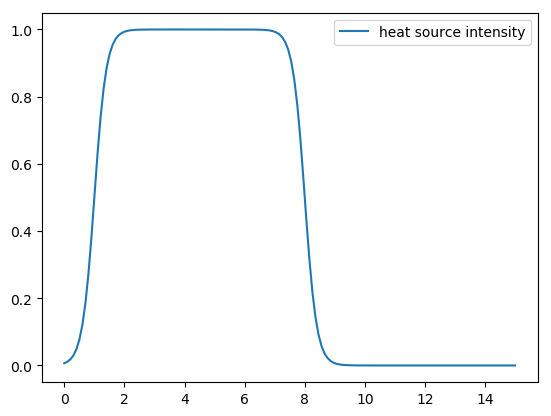

In [7]:
𝑎 = 𝐴 -> (𝑡 -> 𝐴 ./ ((1 + exp.(5*(1 - 𝑡))) .* (1 + exp.(5*(𝑡 - 8)))))

nₜ = 150
𝐭 = linspace(0., 15., nₜ)

𝐴 = 1. # heat source amplitude
𝒂 = 𝑎(𝐴)

plot(𝐭, 𝒂(𝐭))
legend(labels=["heat source intensity"])
;#suppress output

### Simulate heat source

In [8]:
p₀, pₓ = [0.5;0.5], [-1.5;-1.5]

𝑧 = 0.2

0.2

In [9]:
𝐮ₜ = Array{typeof(𝐱[1])}(nₜ) # input function

for k ∈ 1:nₜ
    s  = k ./ nₜ
    pₜ = (1. - s) .* p₀ + s .* pₓ
    𝐮ₜ[k] = 𝒂(𝐭[k]) ./ map(x -> norm(x - pₜ).^2 + 𝑧^2, 𝐱)
end

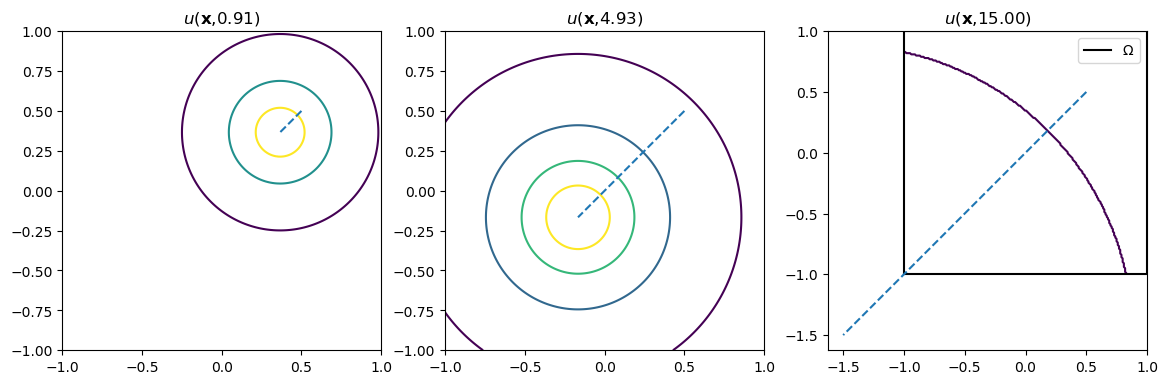

In [10]:
figure(figsize=(14, 8))

c⁺ = maximum(map(maximum, 𝐮ₜ))
c⁻ = minimum(map(minimum, 𝐮ₜ))

logcontour = (x,y,z) -> contour(x, y, log.(z + 1.), linspace(log(c⁻ + 1.), log(c⁺ + 1.), 6))

for (i,k) ∈ enumerate([10, 50, nₜ])
    subplot(130 + i)
    logcontour(𝑥, 𝑦, reshape(𝐮ₜ[k],nₓ, nₓ))
    pₜ = (1. - k./nₜ) .* p₀ + (k./nₜ) .* pₓ
    
    if any(map(s -> abs(s) > 1.0, pₜ))
        plot([-1. -1. 1. 1. -1.]',[-1. 1. 1. -1. -1.]',"k-")
        legend(labels=[L"$\Omega$"])
    end
    
    plot([p₀[1];pₜ[1]], [p₀[2];pₜ[2]],"--")
    
    title(string(L"$u(\mathbf{x}$,",@sprintf("%3.2f",𝐭[k]),L"$)$"))
    axis("square")
end

### Map heat source to Hilbert space representation

In [11]:
𝐮ᵩ = map(uₜ -> map(ϕₙ -> uₜ ⋆ ϕₙ, fₙ), 𝐮ₜ)

𝐮ₚ = [sum([λᵢ * ϕᵢ for (ϕᵢ, λᵢ) ∈ zip(fₙ, uᵩ)]) for uᵩ ∈ 𝐮ᵩ]
; # suppress output

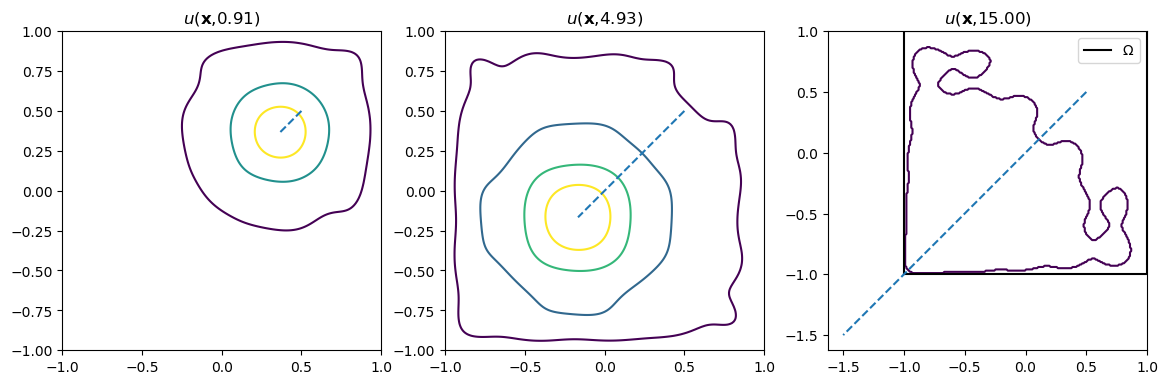

In [12]:
figure(figsize=(14, 8))

for (i,k) ∈ enumerate([10, 50, nₜ])
    subplot(130 + i)
    logcontour(𝑥, 𝑦, reshape(𝐮ₚ[k],nₓ, nₓ))
    
    pₜ = (1. - k./nₜ) .* p₀ + (k./nₜ) .* pₓ
    
    if any(map(s -> abs(s) > 1.0, pₜ))
        plot([-1. -1. 1. 1. -1.]',[-1. 1. 1. -1. -1.]',"k-")
        legend(labels=[L"$\Omega$"])
    end
    
    plot([p₀[1];pₜ[1]], [p₀[2];pₜ[2]],"--")
    
    title(string(L"$u(\mathbf{x}$,",@sprintf("%3.2f",𝐭[k]),L"$)$"))
    axis("square")
end

## Form State Space Model representation

### Process Model
$\mathbf{F} = \text{diag}\left[-k - D\lambda(\mathbf{n})\right], \qquad \mathbf{L} = \mathbf{I}$

$\mathscr{U} = \exp\left(\Delta_t\begin{bmatrix}\mathbf{F} & \mathbf{L} \\ \mathbf{0} & \mathbf{0}\end{bmatrix}\right)$

$\mathscr{A} = \mathscr{U}_{1:n; 1:n}, \qquad \mathscr{B} = \mathscr{U}_{1:n; n+1:2n}$

Where, $k$ is the decay and $D$ is the diffusion constant

$
\tilde{f}_{t+1} = \mathscr{A}\tilde{f}_t + \mathscr{B}\tilde{u}_t
$

$
\mathbf{y}_t = \tilde{f}_t + \nu
$

Where $\nu \sim \mathcal{N}(0, R)$ is a noise term

In [13]:
𝑘, 𝐷, 𝑅 = 0.2, 1e-3, 0.1

ℱ = [ diagm(-𝑘 - 𝐷.*map(λ, 𝐧)) eye(N) ; zeros(N, 2*N) ]

Δₜ = 𝐭[2] - 𝐭[1] # assumes time-invariance
𝒰 = expm(Δₜ*ℱ)

𝒜, ℬ = 𝒰[1:N, 1:N], 𝒰[1:N, N+1:end]

; #suppress output

### Observation Model

Generate sample locations

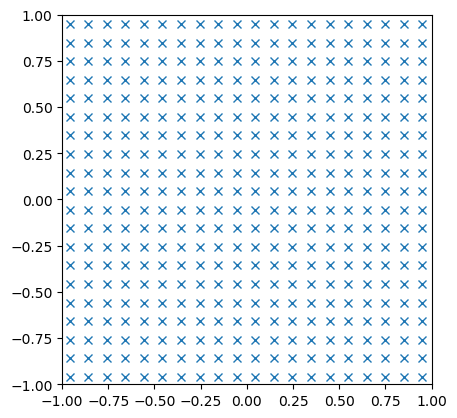

In [14]:
nₛ = (20, 20) # number of samples by dimension. total: nₛ[1] * nₛ[2]
hₘ = [round(Int, nₓ / n) for n ∈ nₛ]

iᵢ = floor(Int, hₘ[1] / 2.):hₘ[1]:ceil(Int, nₓ - hₘ[1] / 2.)
iⱼ = floor(Int, hₘ[2] / 2.):hₘ[2]:ceil(Int, nₓ - hₘ[2] / 2.)

iₘ = [[i,j] for i ∈ iᵢ for j ∈ iⱼ]
mₓ = [[𝑥[i], 𝑦[j]] for (i,j) ∈ iₘ]
iₘ = [(i-1)*nₓ + j for (i,j) in iₘ]
            
plot([x for (x,y) ∈ mₓ],[y for (x,y) ∈ mₓ],"x")
axis(:square)
xlim(-1,1), ylim(-1,1)
; # suppress output

In [15]:
𝒇ᵩ = Array{typeof(𝐮ᵩ[1])}(nₜ)
𝒇ₚ = Array{typeof(𝐮ₚ[1])}(nₜ)
𝐲 = Array{typeof(𝐮ₚ[1])}(nₜ)

𝑓ₜ = zeros(N)



for k = 1:nₜ
    𝑓ₜ = 𝒜 * 𝑓ₜ + ℬ * 𝐮ᵩ[k] # prediction
    
    𝒇ᵩ[k] = 𝑓ₜ
    
    𝒇ₚ[k] = sum([λ * ϕᵢ for (ϕᵢ,λ) ∈ zip(fₙ, 𝒜 * 𝑓ₜ + ℬ * 𝐮ᵩ[k])])
    
    # measurements
    
    𝐲[k] = [ 𝒇ₚ[k][i] + sqrt(𝑅) * randn() for i ∈ iₘ ]
#     𝐲[k] = zeros(s)
#     for i = 1:s
#         𝐲[k][i] = 𝒇ₚ[k][iₘ[i]] + 𝑅 * randn()
#     end
end

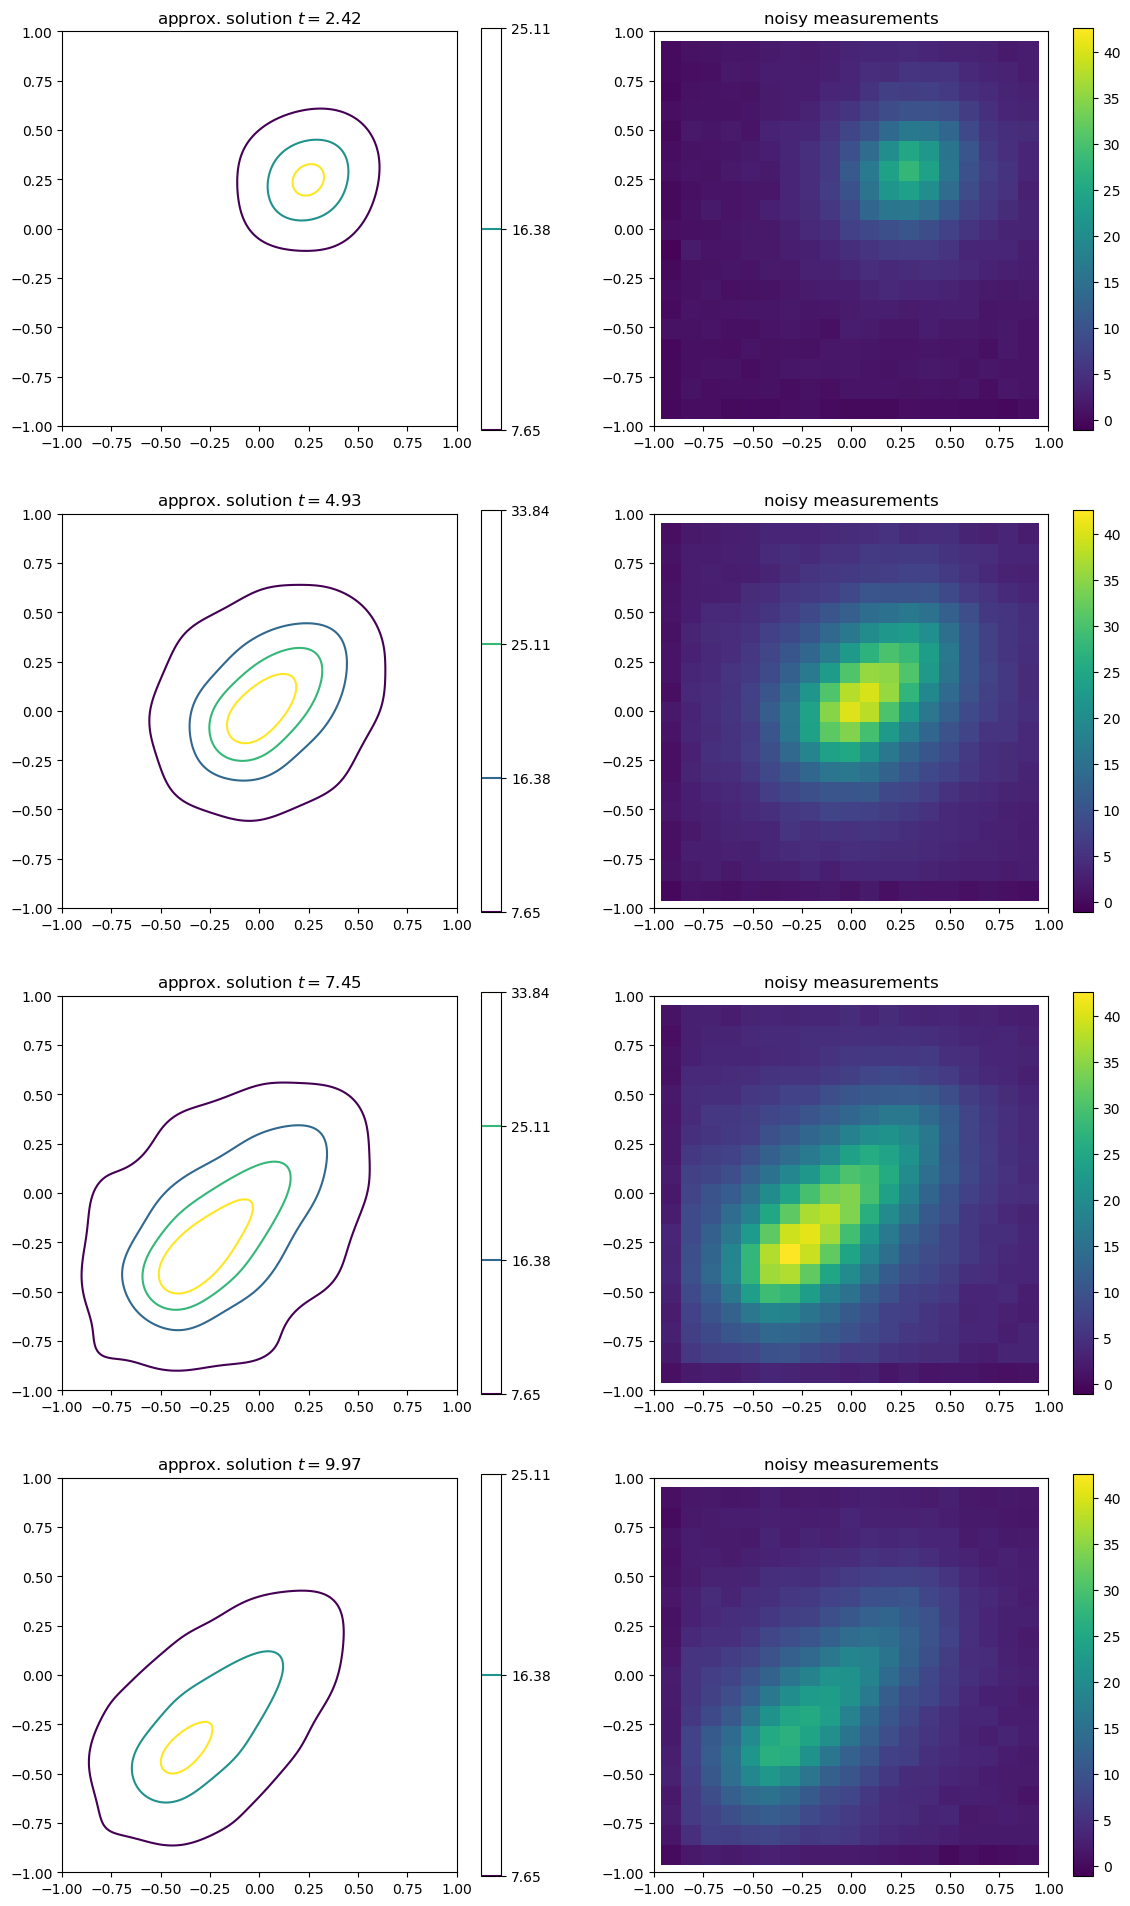

In [16]:
figure(figsize=(14,24))

obs = y -> reshape(y, nₛ[1], nₛ[2])

c⁺ = maximum(map(maximum, 𝐲))
c⁻ = minimum(map(minimum, 𝐲))

for (i,k) ∈ enumerate([25,50,75,100])
    
    subplot(420 + 2(i-1) + 1)
    
    contour(𝑥, 𝑦, reshape(𝒇ₚ[k], nₓ, nₓ), linspace(c⁻, c⁺, 6))
    axis(:square)
    colorbar()
    title(string(L"approx. solution $t = $",@sprintf("%4.2f",𝐭[k])))
    
    subplot(420 + 2i)
        
    pcolor(obs([x for (x,y) ∈ mₓ]), obs([y for (x,y) ∈ mₓ]), obs(𝐲[k]))
    axis(:square)
    clim(c⁻, c⁺)
    xlim(-1,1), ylim(-1,1)
    colorbar()
    title("noisy measurements")

end

## Solve Inverse Heat Equation using Basis Functions

In [17]:
λₙ, fₙ  = map(λ, 𝐧), map(n -> map(ϕ(n), 𝐱), 𝐧); # eigenvalues and eigenfunctions (duplicate of cell[4])

### Approximate spatial covariance function for input

In [18]:
include("GP.jl")

𝜎ₛ, 𝑙ₛ = 100, 0.05 * sqrt(2.)

𝜅ₛ = x -> kern_rbf(norm(x), 0.,θ=Dict("lengthscale" => 𝑙ₛ, "variance" => 𝜎ₛ^2))
𝑆 = 𝜔 -> 𝜎ₛ^2 * 2π * 𝑙ₛ^2 * exp.(- 𝑙ₛ^2 * 𝜔.^2 / 2)

(::#144) (generic function with 1 method)

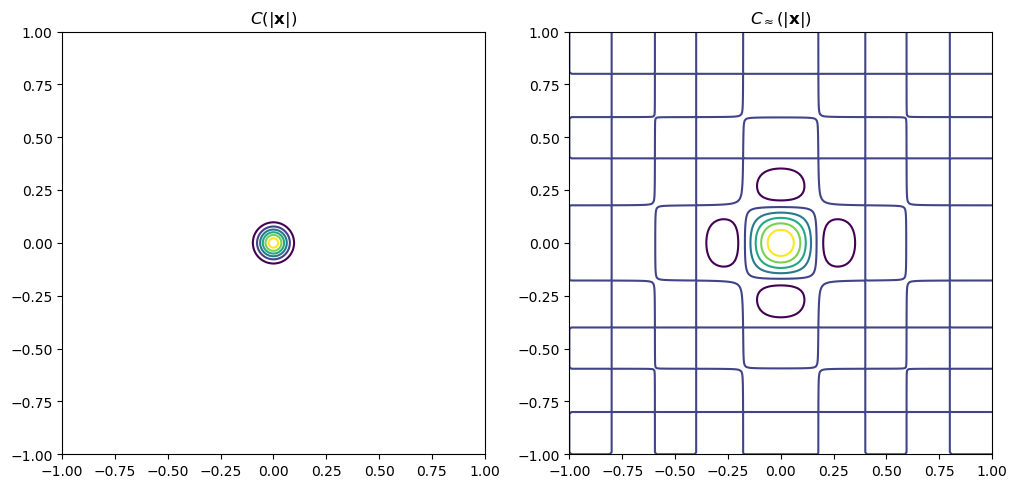

In [19]:
𝐒ₑ = 𝑆(sqrt.(λₙ))

f₀ = map(n -> ϕ(n)([0.;0.]), 𝐧)

𝐶 = reshape([𝜅ₛ(x) for x ∈ 𝐱], nₓ, nₓ) # covariance function
𝐶ₐ = reshape(sum([λᵢ * fᵢ * ϕᵢ for (λᵢ, fᵢ, ϕᵢ) ∈ zip(λₙ, f₀, fₙ)],1)[1], nₓ, nₓ) # basis function representation

𝑄ᶜ = diagm([𝑆(sqrt.(𝜆)) for 𝜆 ∈ λₙ])

figure(figsize=(12,7))

subplot(121)
contour(𝑥, 𝑦, 𝐶)
axis(:square)
title(L"$C(\|\mathbf{x}\|)$")

subplot(122)
contour(𝑥, 𝑦, 𝐶ₐ)
axis(:square)
title(L"$C_\approx(\|\mathbf{x}\|)$")

;#suppress output

### Approximate temporal covariance

In [20]:
function padé(c, m, n = nothing, a₀ = 1.)
    # Padé approximant for M/N series
    
    N = length(c)
    
    if n == nothing
        n = N - 1 - m
    end
    
    if N ≠ m + n + 1
        println("something went wrong: length(c) ≠ M + N + 1")
        return nothing
    end
    
    G = zeros(n, n)
    
    for i ∈ 1:n
        i₁ = m + i - 1
        i₂ = m + i - n
        
        Gᵢ = c[(N-i₁):(N-max(i₂,0))] 
        G[i,length(Gᵢ):-1:1] = Gᵢ
    end
    
    y = -a₀ * c[n:-1:1]
    
    a = [(G\y) ; a₀]
    b = conv(c, a)[end-m:end]
    
    return a, b
end

function κ_padé(m, n, 𝜎, 𝑙)
    𝒪 = m + n # order
    
    N = 𝒪:-1:0
    
    c = (𝑙^2/2).^N ./ factorial.(N)

    b,a = padé(c, n, m) # flipped order for some reason
    #b, a = Pade(Poly(c), n, m)
    A, B = zeros(2*length(a) - 1), zeros(2*length(b) - 1)
    A[1:2:end], B[1:2:end] = a, b
    
    B = B .* 𝜎^2 * sqrt(2π) * 𝑙
    
    return B[end:-1:1], A[end:-1:1]
end



κ_padé (generic function with 1 method)

In [21]:
using Polynomials

function sd_to_ssm(B, A, rtype = :canonical)
    
    Aₚ, Bₚ = Poly(A), Poly(B)
    
    q = polyval(Bₚ, 0.) / polyval(Aₚ, 0.)
    
    Lᴬ, Lᴮ = Poly(A ./ im .^ (0:length(A)-1)), Poly(B ./ im .^ (0:length(B)-1))
    
    Aᴿ, Bᴿ = roots(Lᴬ), roots(Lᴮ)

    Gᴬ, Gᴮ = poly(Aᴿ[[real(r) < 0. for r ∈ Aᴿ]]), poly(Bᴿ[[real(r) < 0. for r ∈ Bᴿ]])
    
    Gᴬ /= Gᴬ[0]
    Gᴮ /= Gᴮ[0]
    Gᴮ /= Gᴬ[end] # this could be a bug
    Gᴬ /= Gᴬ[end]

    if rtype == :canonical
        F = zeros(length(Gᴬ) - 1, length(Gᴬ) - 1)
        
        F[end, :] = -abs.(Gᴬ[0:end-1])
        F[1:end-1, 2:end] = eye(length(Gᴬ) - 2)
        
        L = zeros(length(Gᴬ) - 1, 1)
        L[end] = 1.
        
        H = zeros(1,length(Gᴬ) - 1)
        H[1:length(Gᴮ)] = abs.(Gᴮ[0:end])
    
    elseif rtype == :observable
       
    else
        println("unexpected rtype, should be :canonical or :observable")
        return nothing
    end

    return F, L, q, H
end

sd_to_ssm (generic function with 2 methods)

In [22]:
𝜎ₜ, 𝑙ₜ = 1., 0.5
m, n = 4, 8 # padé approximant order (m/n)

𝜅ₜ = t -> 𝜎ₜ^2 * exp.(-t.^2 / (2𝑙ₜ^2))
ℬₜ, 𝒜ₜ = κ_padé(m, n, 𝜎ₜ, 𝑙ₜ)

; #suppress output

In [23]:
F, L, q, H = sd_to_ssm(ℬₜ, 𝒜ₜ)

# Balance
(_, _, scale) = LAPACK.gebal!('B',F)
L = diagm(scale)\L
H = H * diagm(scale)

; #suppress output

In [24]:
function lyapchol(A, B)
    return cholfact(Hermitian(lyap(A, B*B')))[:U]
end

function 𝐾(𝛕, F, L, q, H)
    Lq = L*√q
    P∞ = lyapchol(F, Lq)
    
    P∞ = P∞' * P∞
    
    𝐾ₐ = zeros(size(𝛕))
    
#     𝐾ₐ[[𝜏 ≥ 0 for 𝜏 ∈ 𝛕]] = map(𝜏 -> H*P∞*expm(𝜏*F)*H',   [𝜏 ≥ 0 for 𝜏 ∈ 𝛕])
#     𝐾ₐ[[𝜏 < 0 for 𝜏 ∈ 𝛕]] = map(𝜏 -> H*expm(-𝜏*F)*P∞*H'), [𝜏 < 0 for 𝜏 ∈ 𝛕])
    𝐾ₐ = [𝜏 ≥ 0 ? H*P∞*expm(𝜏*F)'*H' : H*expm(-𝜏*F)*P∞*H' for 𝜏 ∈ 𝛕]
    # flatten
    𝐾ₐ = [c[1] for c ∈ 𝐾ₐ]
end

𝛕 = -5*𝑙ₜ:𝑙ₜ/10.:5*𝑙ₜ
Cₜ = 𝐾(𝛕, F, L, q, H)

Pₜ = lyapchol(F, L*√q)
Pₜ = Pₜ' * Pₜ

;#suppress output

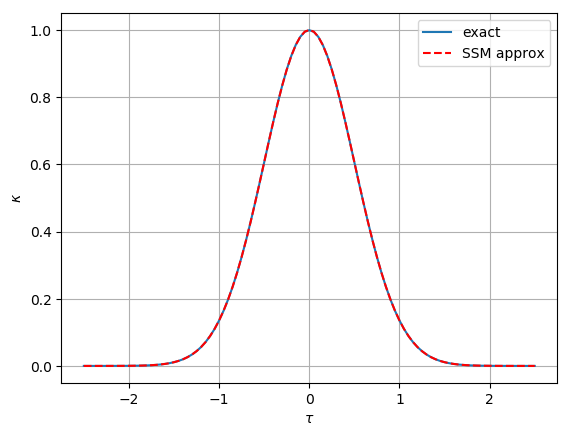

In [25]:
plot(𝛕, map(𝜅ₜ, 𝛕), "-")
plot(𝛕, Cₜ,"r--")
xlabel(L"\tau"), ylabel(L"\kappa")
legend(labels=["exact", "SSM approx"])
grid(:on)

### Form State Space Model

In [26]:
## Basis function representation of observation locations
𝝋 = reshape([ϕₙ[x] for  ϕₙ ∈ fₙ for x ∈ iₘ], prod(nₛ), N) # observation locations
; # suppress output

In [27]:
Fᵤ = kron(eye(N), F)
Lᵤ = sqrt(q) * kron(eye(N), L)
Hᶜ, Hᵤ = kron(eye(N), H), kron(𝝋, H) # plain coefficients and projection to measurement points

Pᵤ = lyap(Fᵤ, Lᵤ*𝑄ᶜ*Lᵤ')
; #suppress output

In [28]:
Fᵩ = diagm(-𝑘 - 𝐷 * λₙ)
Lᵩ = eye(N)
Hᵩᶜ, Hᵩ = eye(N), 𝝋
; # suppress output

In [29]:
𝐅  = [Fᵩ (Lᵩ * Hᶜ) ; zeros(n*N,N) Fᵤ]

𝐋  = [zeros(N, N) ; Lᵤ]
𝐋ᶜ = [Lᵩ ; zeros(n*N, N)]

𝐇   = [Hᵩ zeros(m*N, n*N)]
𝐇ᶜ  = [Hᵩᶜ zeros(N, n*N)]
𝐇ᵤ  = [zeros(m*N, N) Hᵤ]
𝐇ᵤᶜ = [zeros(N, N) Hᶜ]
; # suppress output

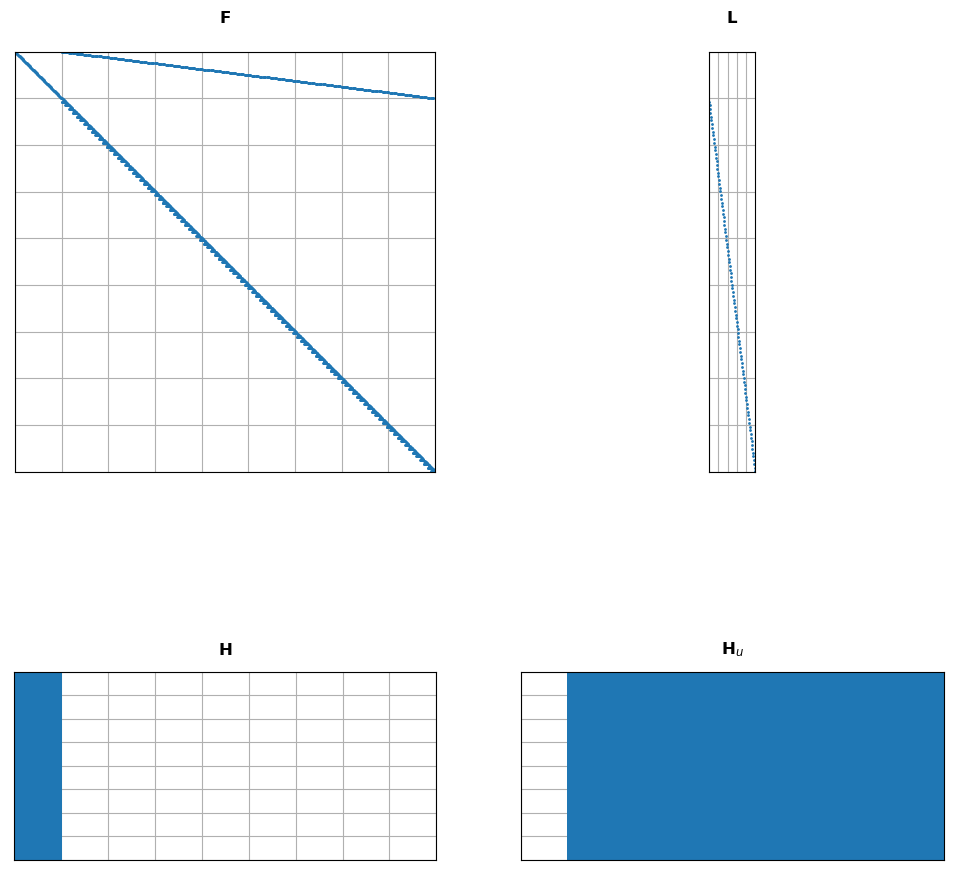

(PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fc135f60518>, PyObject Text(0.5,1.05,'$\\mathbf{H}_u$'))

In [30]:
function plotmat(A, _title="")
    spy(A, marker=".", markersize=2)
    tick_params(
        axis="both",
        which="both",
        top=false,
        bottom=false,
        left=false,
        right=false,
        labeltop=false,
        labelleft=false
    )
    grid()
    title(_title)
end

figure(figsize=(12,12))

subplot(221), plotmat(𝐅, L"$\mathbf{F}$")

subplot(222), plotmat(𝐋, L"$\mathbf{L}$" )

subplot(223), plotmat(𝐇, L"$\mathbf{H}$")

subplot(224), plotmat(𝐇ᵤ, L"$\mathbf{H}_u$")

### Discretisation

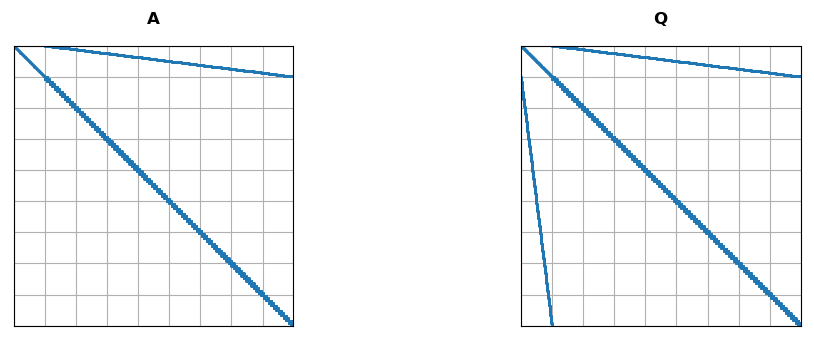

In [31]:
𝐀 = expm(𝐅 * Δₜ)
𝐏 = lyap(𝐅, 𝐋*𝑄ᶜ*𝐋')
𝐐 = 𝐏 - 𝐀*𝐏*𝐀'

figure(figsize=(12,8))

subplot(221), plotmat(𝐀, L"$\mathbf{A}$")

subplot(222), plotmat(𝐐, L"$\mathbf{Q}$")
;# suppress output

In [32]:
𝐀[end-8:end, end-8:end]

9×9 Array{Float64,2}:
 -0.198229   0.0          0.0         …   0.0           0.0       
  0.0        0.999998     0.201338        0.000156662   8.34874e-5
  0.0       -9.02134e-5   0.999835        0.00441603    0.00259396
  0.0       -0.00140147  -0.00256511      0.0502721     0.0330737 
  0.0       -0.00893456  -0.0164157       0.214745      0.162582  
  0.0       -0.0439199   -0.0812066   …   0.581641      0.54017   
  0.0       -0.145922    -0.273364        0.407155      0.739988  
  0.0       -0.0499752   -0.0989812      -0.674413     -0.525859  
  0.0        0.017757     0.0303674      -0.0929378    -0.198229  

## Kalman Filter

#### Prediction
$\mathbf{m}_{t|t-1} = \mathbf{A}\mathbf{m}_{t-1}$

$\mathbf{P}_{t|t-1} = \mathbf{A}\mathbf{P}_{t-1}\mathbf{A}^\text{T} + \mathbf{Q}$

#### Update

$\mathbf{S}_t = \mathbf{H}\mathbf{P}_{t|t-1}\mathbf{H}^\text{T} + \mathbf{R}$

$\mathbf{K}_t = \mathbf{P}_{t|t-1}\mathbf{H}^\text{T}\left(\mathbf{S}_t\right)^{-1}$

$\mathbf{m}_{t|t} = \mathbf{m}_{t|t-1} + \mathbf{K}_t\left(\varphi_t - \mathbf{H}\mathbf{m}_{t|t-1}\right)$

$\mathbf{P}_{t|t} = \mathbf{P}_{t|t-1} - \mathbf{K}_t\mathbf{S}_t\mathbf{K}_t^\text{T}$

In [44]:
𝛍ₓ, 𝛍ᵤ = Array{typeof(𝐱[1])}(nₜ), Array{typeof(𝐱[1])}(nₜ)

𝐦₀ = zeros(N + n*N)
𝐏₀ = [ eye(N,N) zeros(N, n*N) ; zeros(n*N, N) Pᵤ]

𝛍ᵩ, 𝚺ᵩ  = Array{typeof(𝐦₀)}(nₜ), Array{typeof(𝐏₀)}(nₜ)

𝐦ₜ, 𝐏ₜ = 𝐦₀, 𝐏₀

𝐑 = 𝑅 * eye(prod(nₛ))

; # suppress output

In [45]:
# Kalman filter
function _proto_predict(m, P, F, Q)
    return F*m, F*P*F' + Q 
end

function _proto_update(m, P, y, H, R)
    S = H*P*H' + R
    K = P*H' / S
    return (m + K*(y - H*m), P - K*S*K')
end
filter = (F, Q, H, R) -> ((m, P) -> _proto_predict(m, P, F, Q), (m, P, y) -> _proto_update(m, P, y, H, R))
#filter = (F, Q, H, R) -> ((m,P) -> (F*m, F*P*F' + Q), (m,P,y) -> (m + (P*H'/(H*P*H'+R))*(y-H*m), P - (P*H'/(H*P*H'+R))*(H*P*H'+R)*(P*H'/(H*P*H'+R))'))

predict, update = filter(𝐀, 𝐐, 𝐇, 𝐑)

(#203, #204)

### Plotting utilities

In [35]:
function _proto_contour(z, _title="", min=nothing, max=nothing, lvl=8)
    contour(𝑥, 𝑦, reshape(z, nₓ, nₓ), linspace(min, max, lvl))
    #colorbar()
    axis(:square)
    title(_title)
end

𝒇ₘₐₓ, 𝐮ₘₐₓ = maximum(map(maximum, 𝒇ₚ)), maximum(map(maximum, 𝐮ₚ))
𝒇ₘᵢₙ, 𝐮ₘᵢₙ = minimum(map(minimum, 𝒇ₚ)), minimum(map(minimum, 𝐮ₚ))

contour_f = (f, title) -> _proto_contour(f, title, 𝒇ₘᵢₙ, 𝒇ₘₐₓ, 8)
contour_u = (u, title) -> _proto_contour(u, title, 𝐮ₘᵢₙ, 𝐮ₘₐₓ, 8)

(::#184) (generic function with 1 method)

In [36]:
function _proto_pcolor(z, _title="", min=nothing, max=nothing)
    pcolor(𝑥, 𝑦, reshape(z, nₓ, nₓ))
    clim(min, max)
    #colorbar()
    axis(:square)
    title(_title)
end

𝒇ₘₐₓ, 𝐮ₘₐₓ = maximum(map(maximum, 𝒇ₚ)), maximum(map(maximum, 𝐮ₚ))
𝒇ₘᵢₙ, 𝐮ₘᵢₙ = minimum(map(minimum, 𝒇ₚ)), minimum(map(minimum, 𝐮ₚ))

pcolor_f = (f, title) -> _proto_pcolor(f, title, 𝒇ₘᵢₙ, 𝒇ₘₐₓ)
pcolor_u = (u, title) -> _proto_pcolor(u, title, 𝐮ₘᵢₙ, 𝐮ₘₐₓ)


(::#188) (generic function with 1 method)

In [46]:
for k = 1:nₜ
    # Kalman filter predict / update
    𝐦ₜ, 𝐏ₜ = predict(𝐦ₜ, 𝐏ₜ)
    𝐦ₜ, 𝐏ₜ = update(𝐦ₜ, 𝐏ₜ, 𝐲[k])
    
    𝛍ᵩ[k], 𝚺ᵩ[k] = 𝐦ₜ, 𝐏ₜ
    
    𝛍ₓ[k] = sum([λ * ϕᵢ for (ϕᵢ,λ) ∈ zip(fₙ, 𝐇ᶜ*𝐦ₜ)])
    𝛍ᵤ[k] = sum([λ * ϕᵢ for (ϕᵢ,λ) ∈ zip(fₙ, 𝐇ᵤᶜ*𝐦ₜ)])
end

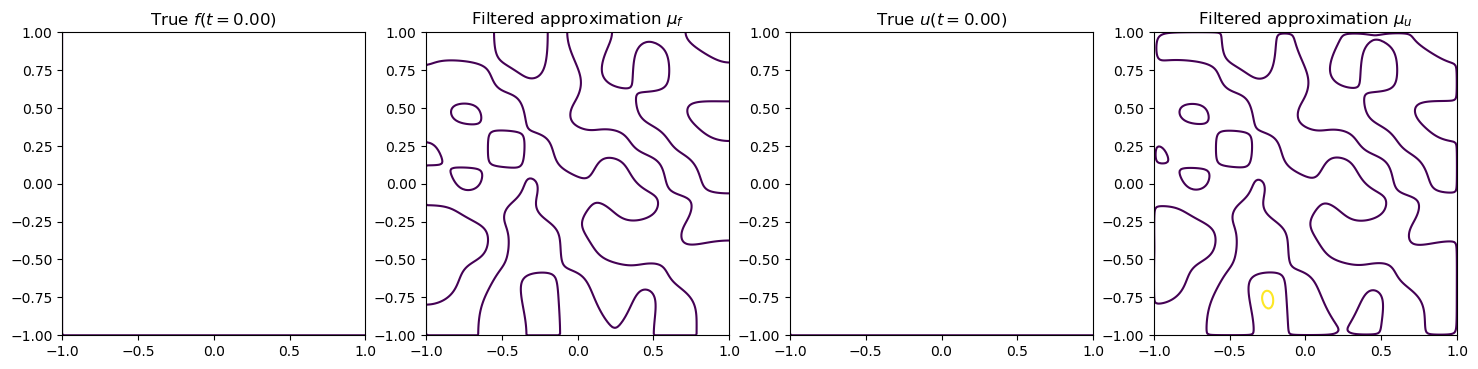

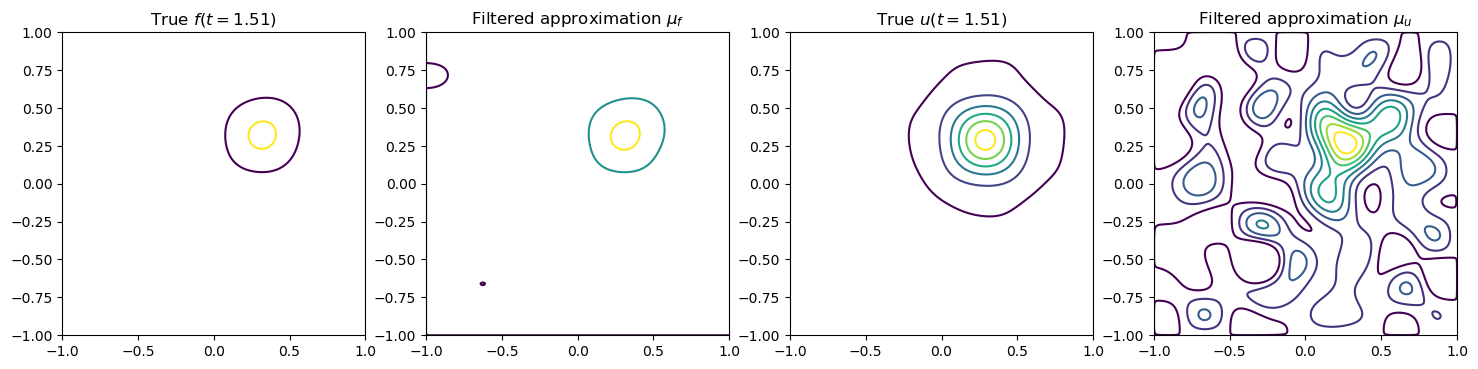

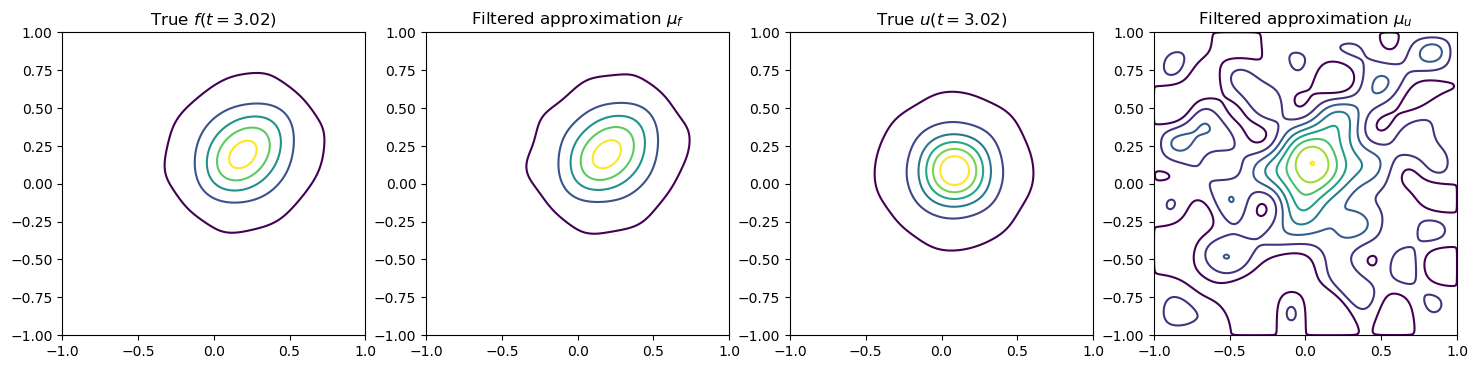

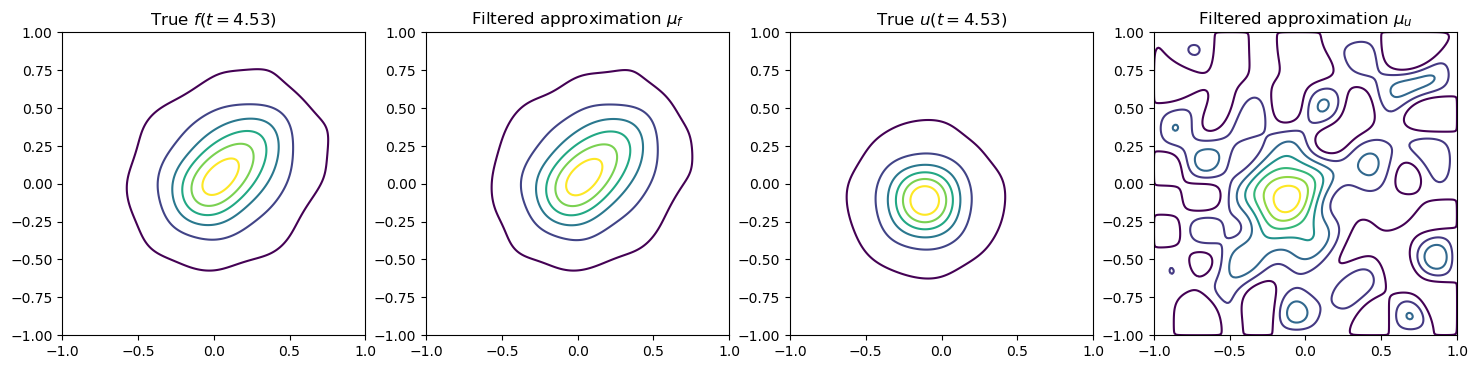

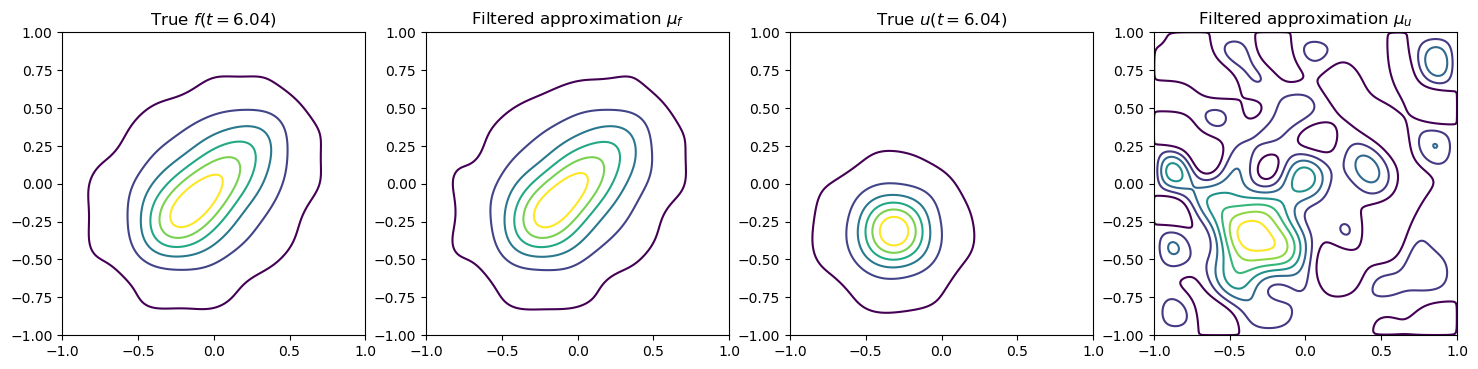

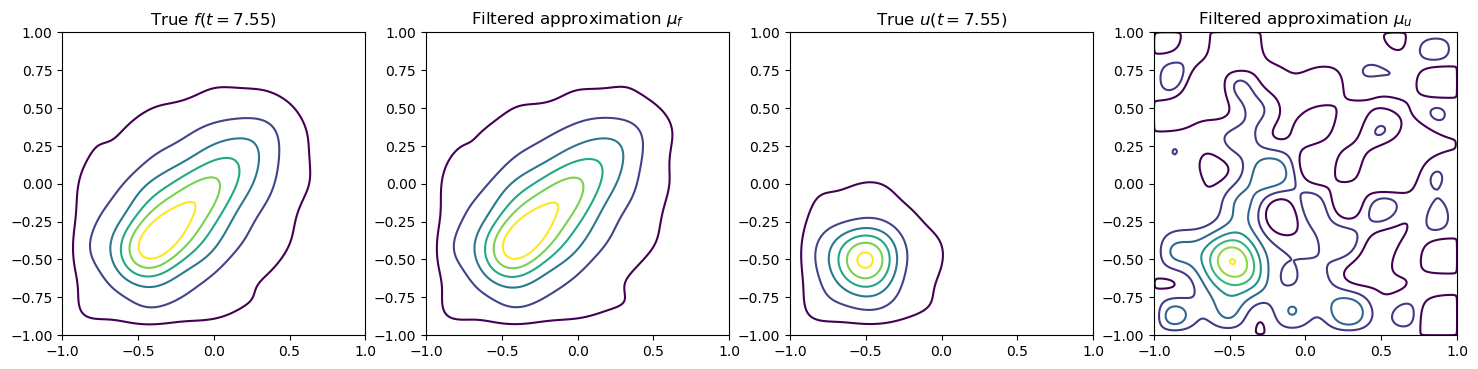

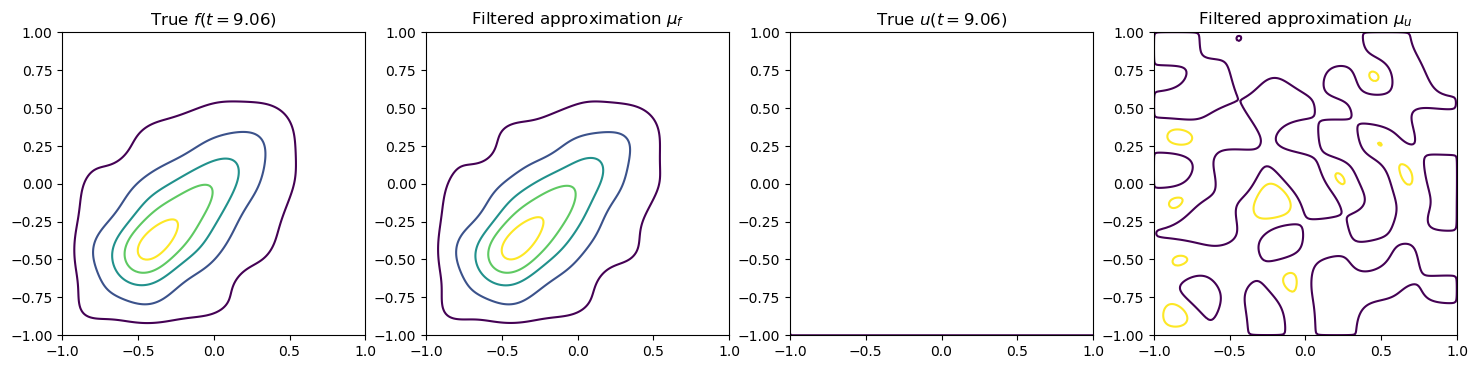

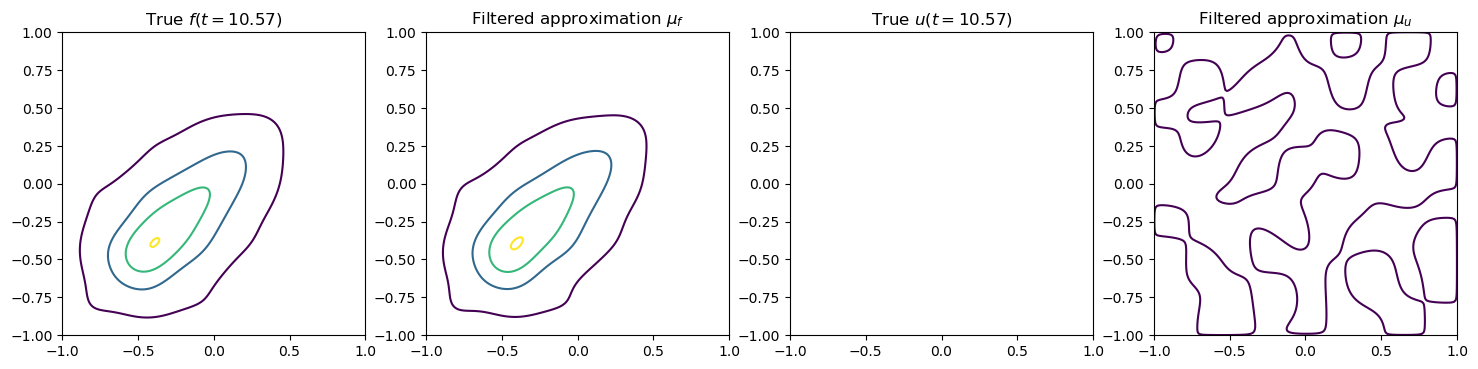

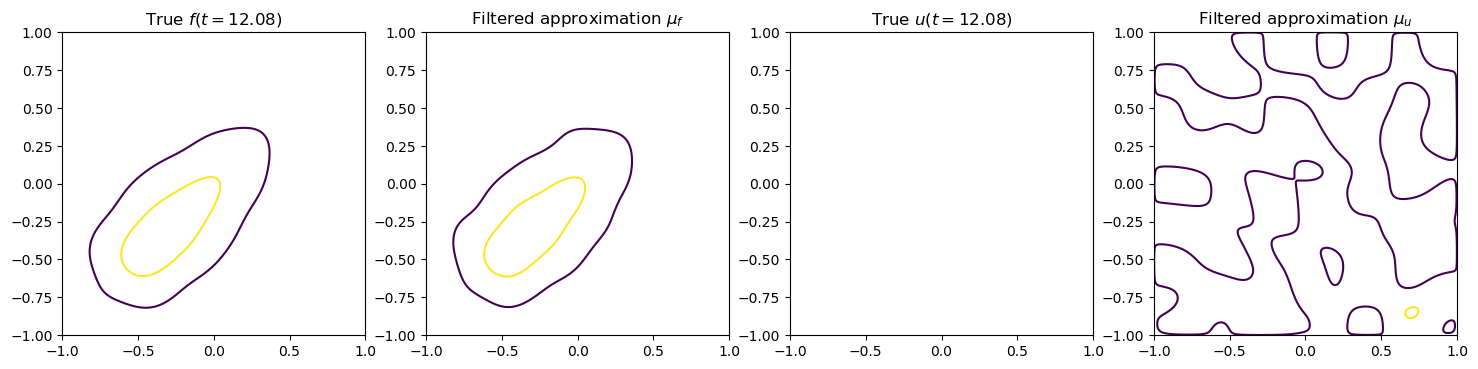

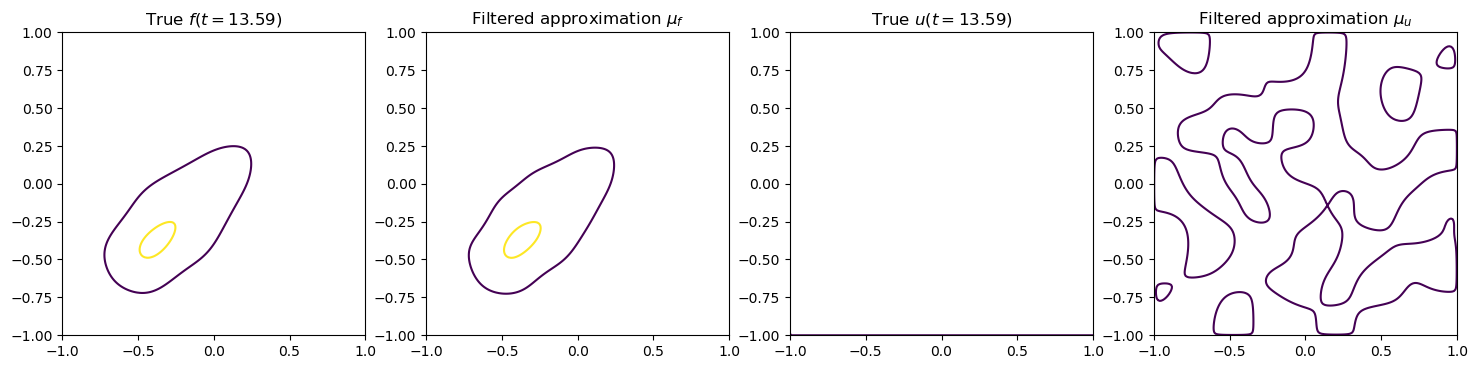

In [47]:
function plotfilter(k, μₓ, μᵤ)
    figure(figsize=(18, 6))
    
    subplot(141), contour_f(𝒇ₚ[k], string(L"True $f(t=$",@sprintf("%4.2f", 𝐭[k]), L"$)$"))
    
    subplot(142), contour_f(μₓ, L"Filtered approximation $\mu_f$")
    
    subplot(143), contour_u(𝐮ₚ[k], string(L"True $u(t=$",@sprintf("%4.2f", 𝐭[k]), L"$)$"))
        
    subplot(144), contour_u(μᵤ, L"Filtered approximation $\mu_u$")
end

for k = 1:15:nₜ
    plotfilter(k, 𝛍ₓ[k], 𝛍ᵤ[k])
end

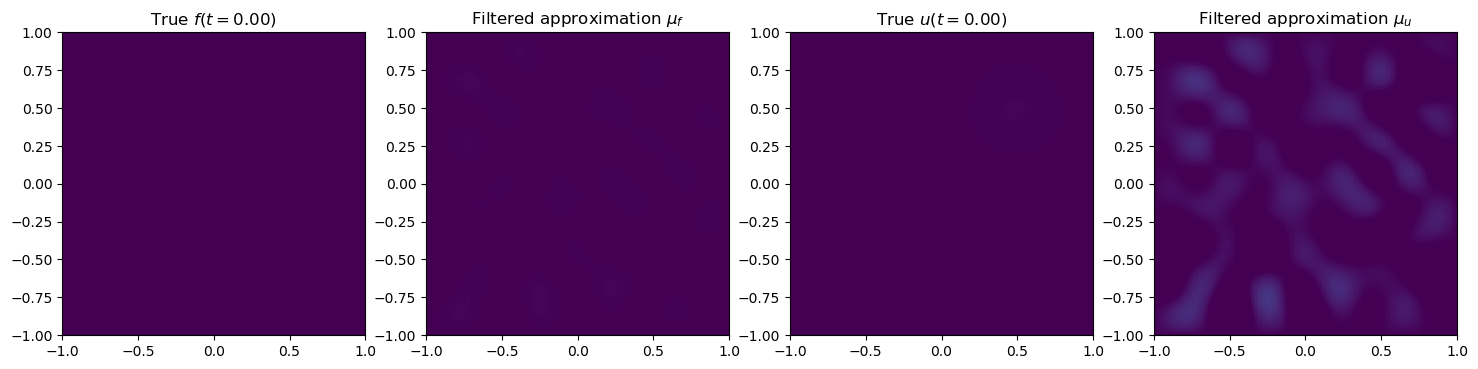

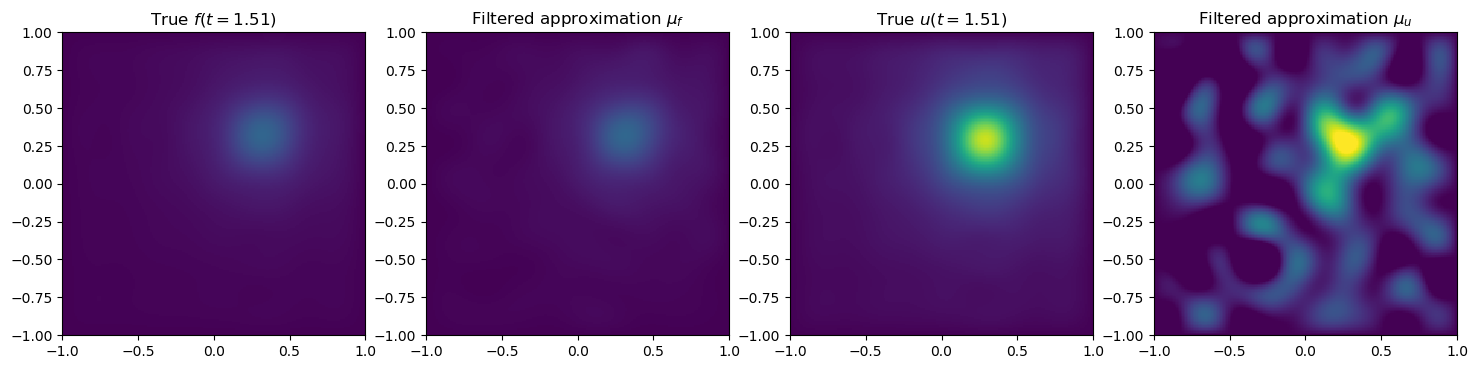

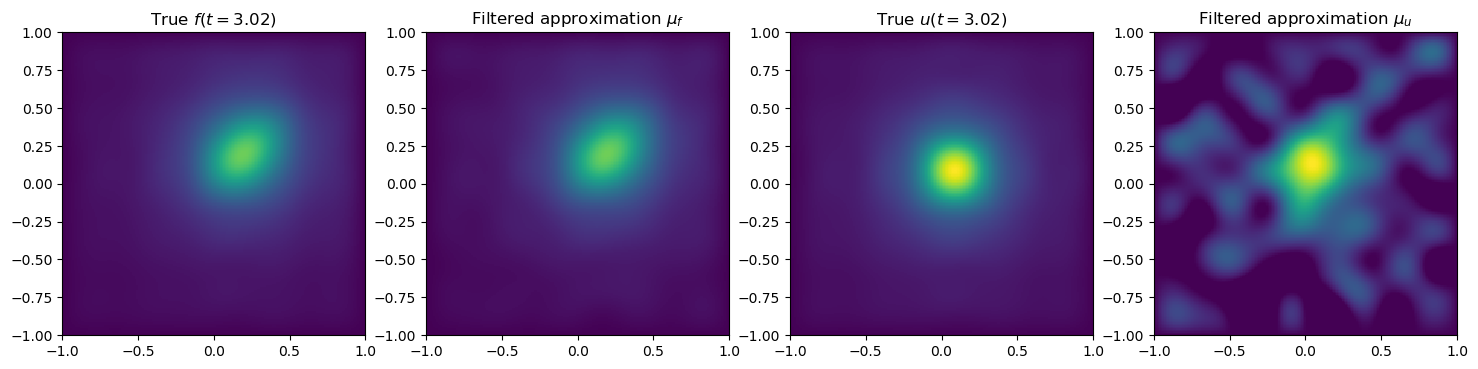

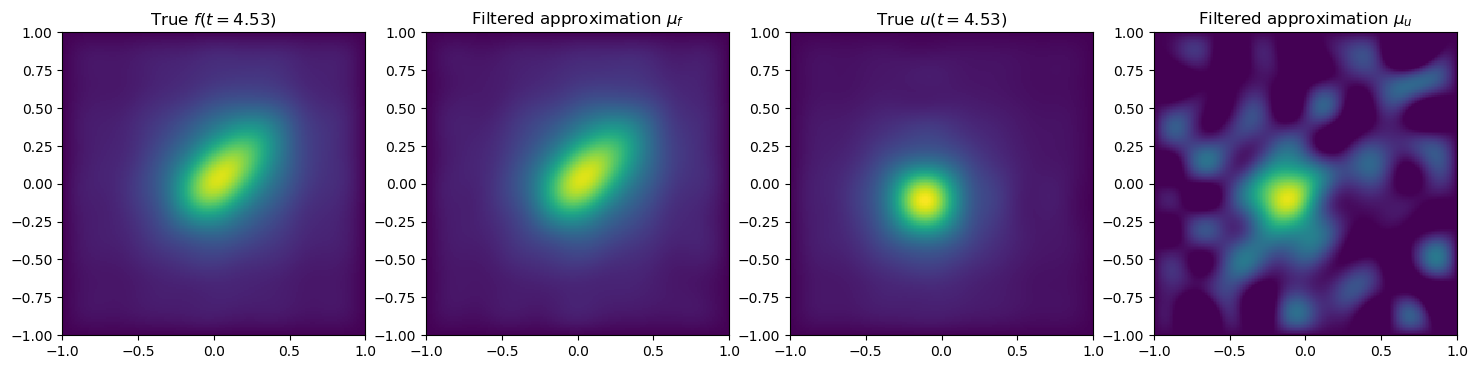

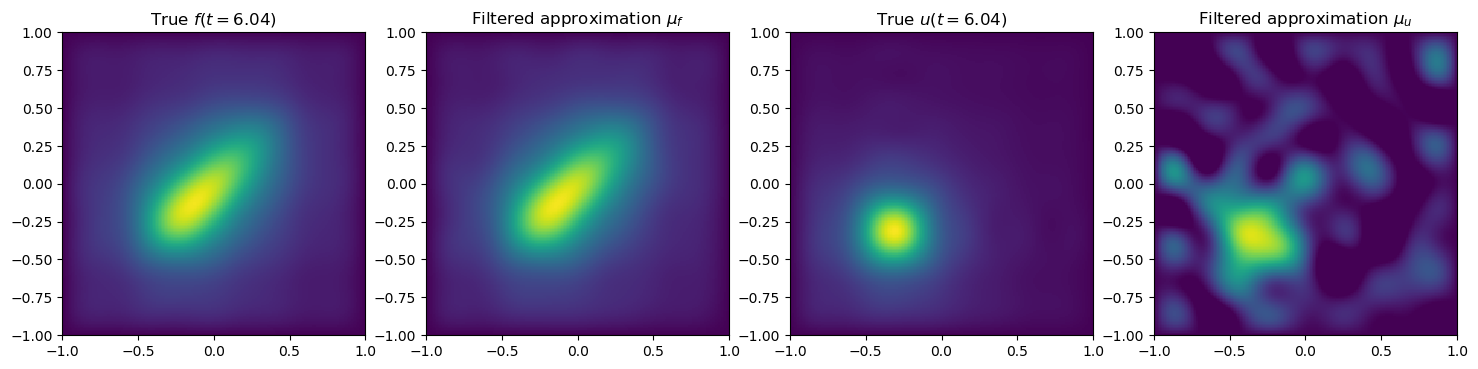

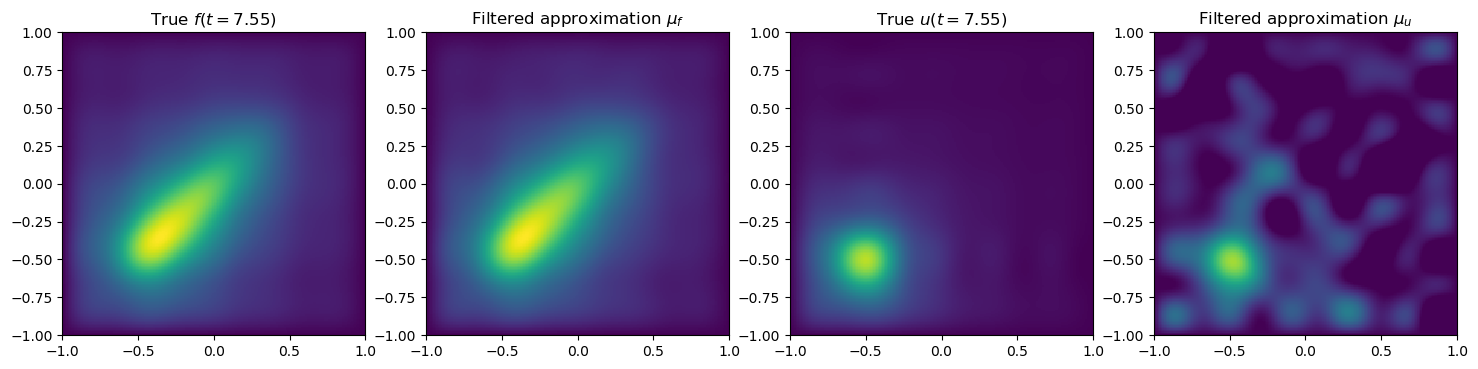

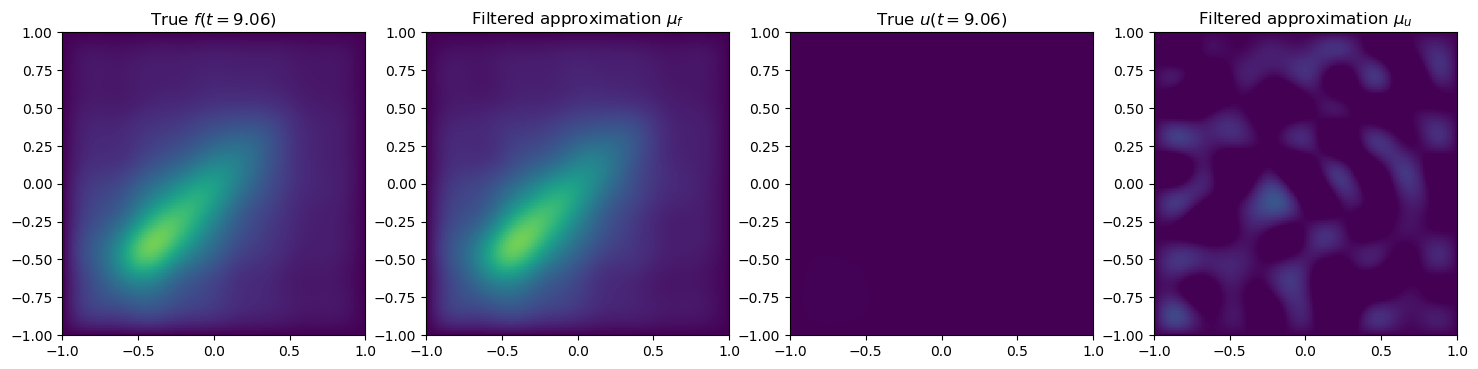

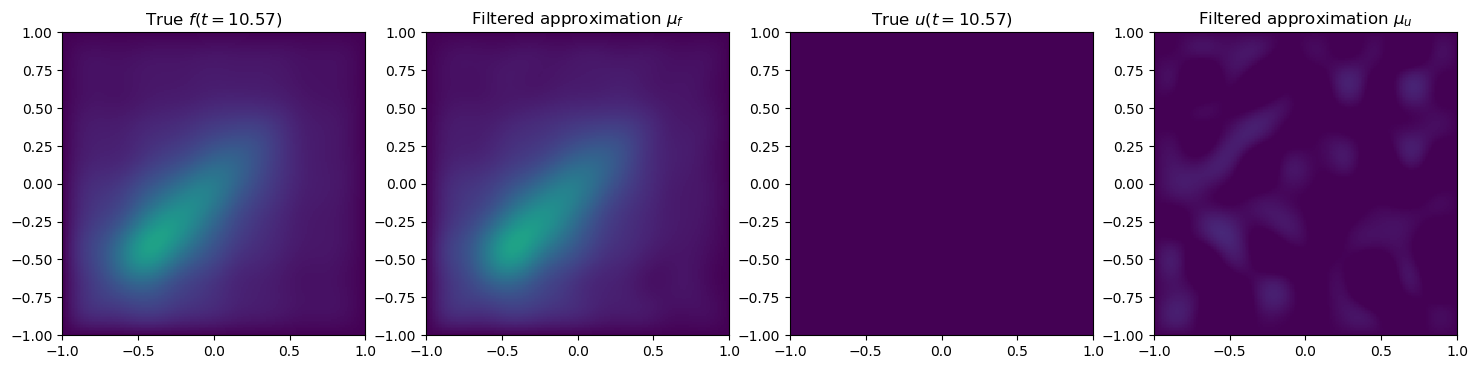

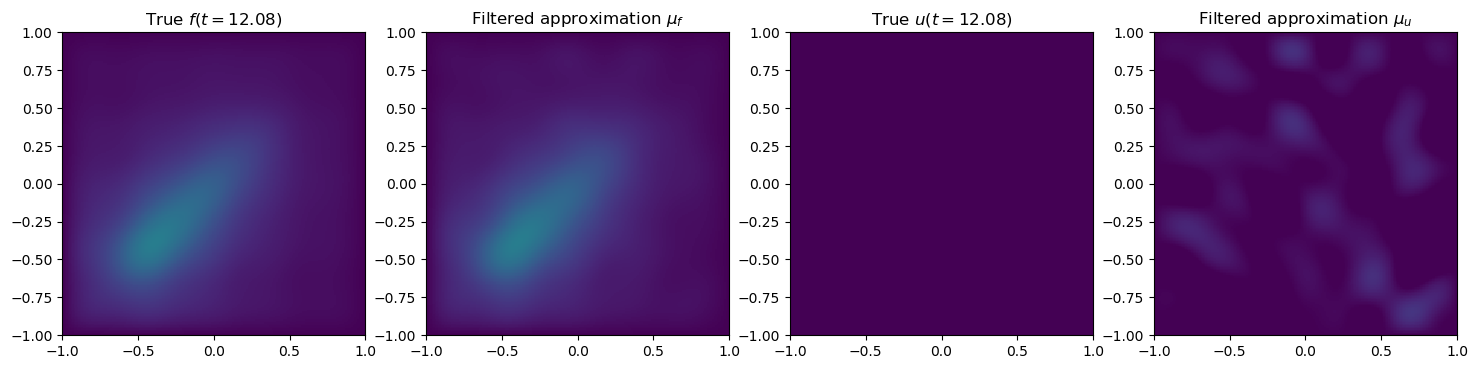

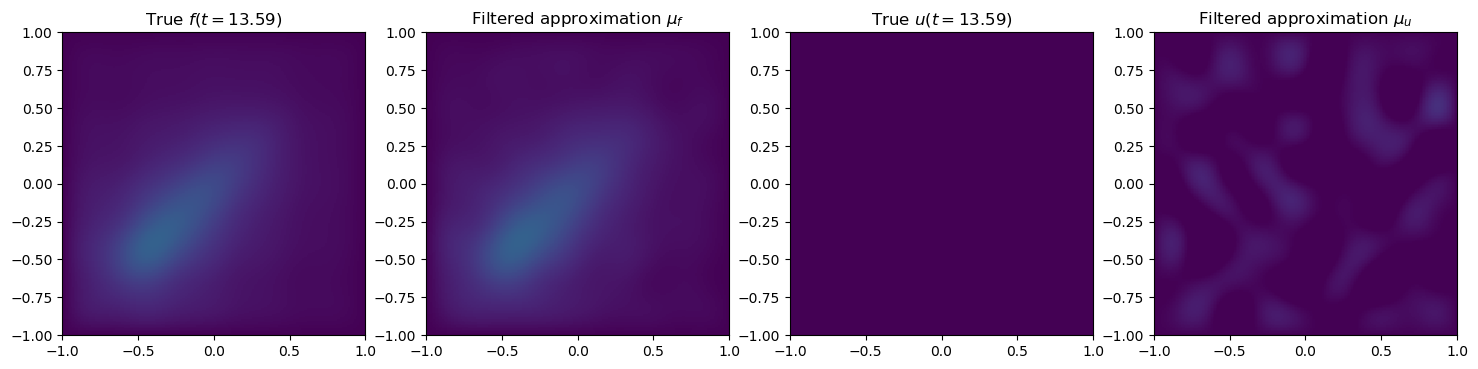

In [48]:
function colourfilter(k, μₓ, μᵤ)
    figure(figsize=(18, 6))
    
    subplot(141), pcolor_f(𝒇ₚ[k], string(L"True $f(t=$",@sprintf("%4.2f", 𝐭[k]), L"$)$"))
    
    subplot(142), pcolor_f(μₓ, L"Filtered approximation $\mu_f$")
    
    subplot(143), pcolor_u(𝐮ₚ[k], string(L"True $u(t=$",@sprintf("%4.2f", 𝐭[k]), L"$)$"))
        
    subplot(144), pcolor_u(μᵤ, L"Filtered approximation $\mu_u$")
end

for k = 1:15:nₜ                                       
    colourfilter(k, 𝛍ₓ[k], 𝛍ᵤ[k])
end

In [49]:
function _proto_smooth(m⁻,m⁺,P⁻,P⁺, F, Q)
    
    mₚ, Pₚ = predict(m⁻,P⁻)
    
    G = P⁻*F'/Pₚ
    
    return m⁻ + G*(m⁺ - mₚ), P⁻ + G*(P⁺ - Pₚ)*G'
end

smoother = (F,Q)->((m⁻,m⁺,P⁻,P⁺)->_proto_smooth(m⁻,m⁺,P⁻,P⁺, F, Q))
smooth = smoother(𝐅, 𝐐)

(::#213) (generic function with 1 method)

In [50]:
# Smoothing
𝛍ₛ, 𝚺ₛ  = Array{typeof(𝐦₀)}(nₜ), Array{typeof(𝐏₀)}(nₜ)

𝛍ₛ[end], 𝚺ₛ[end] = 𝛍ᵩ[end], 𝚺ᵩ[end]

for k = nₜ-1:-1:1    
    𝐦ₜ, 𝐏ₜ = smooth(𝛍ᵩ[k],𝛍ₛ[k+1],𝚺ᵩ[k],𝚺ₛ[k+1])
    
    𝛍ₛ[k], 𝚺ₛ[k] = 𝐦ₜ, 𝐏ₜ
    
    𝛍ₓ[k] = sum([λ * ϕᵢ for (ϕᵢ,λ) ∈ zip(fₙ, 𝐇ᶜ*𝐦ₜ)])
    𝛍ᵤ[k] = sum([λ * ϕᵢ for (ϕᵢ,λ) ∈ zip(fₙ, 𝐇ᵤᶜ*𝐦ₜ)])
end

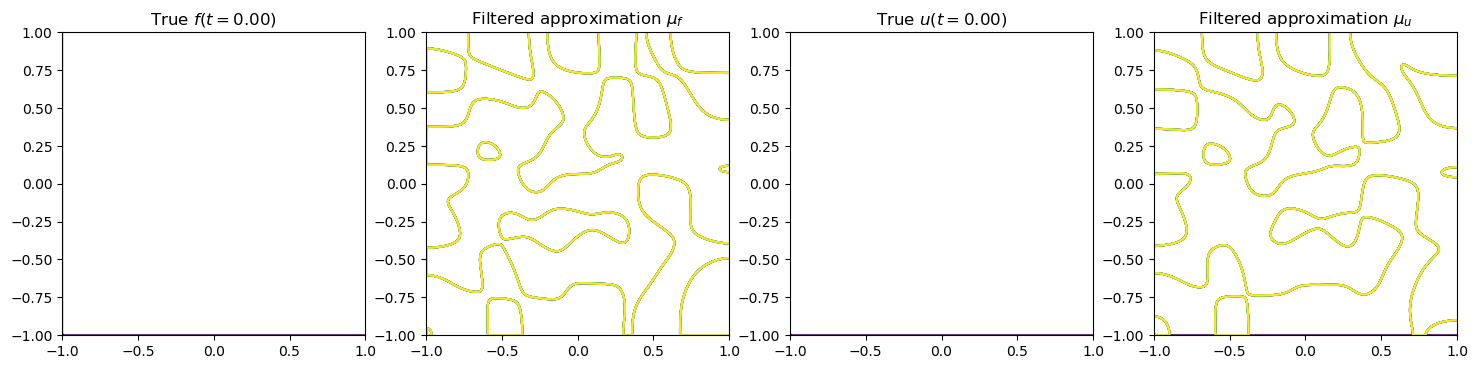

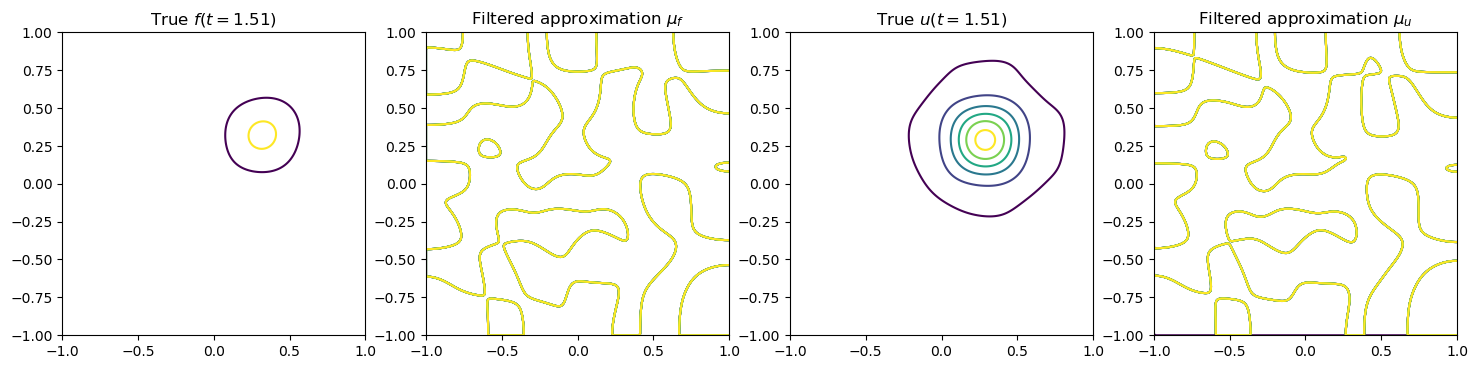

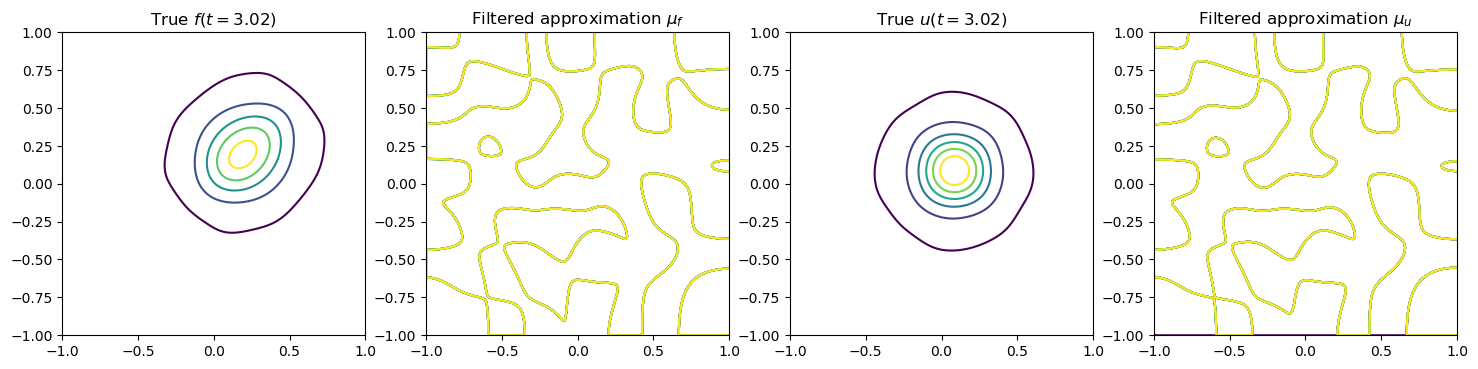

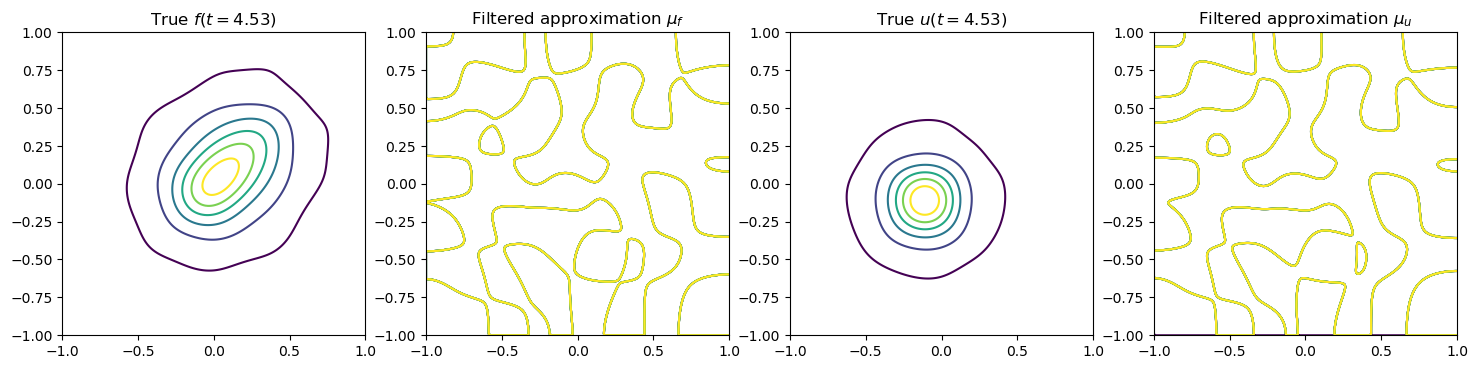

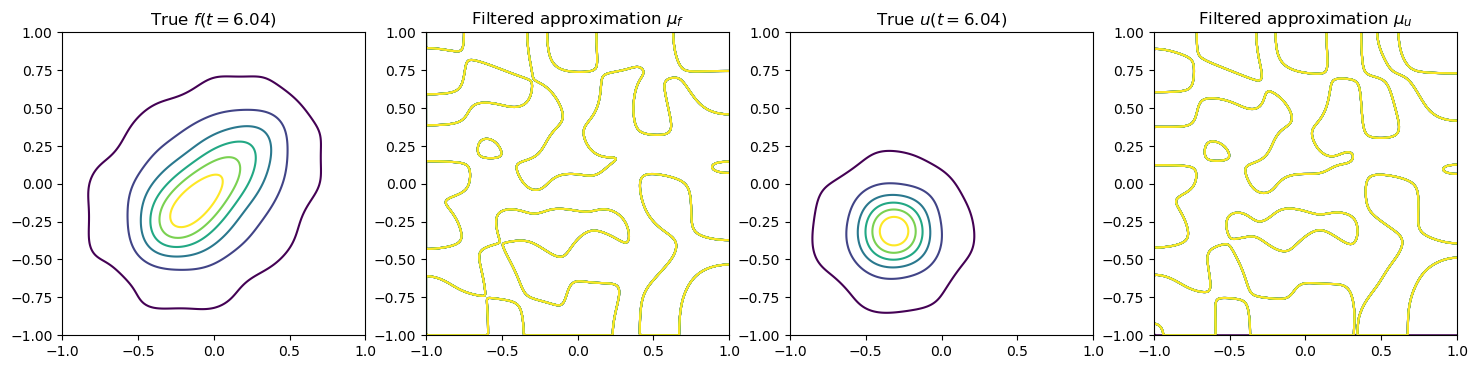

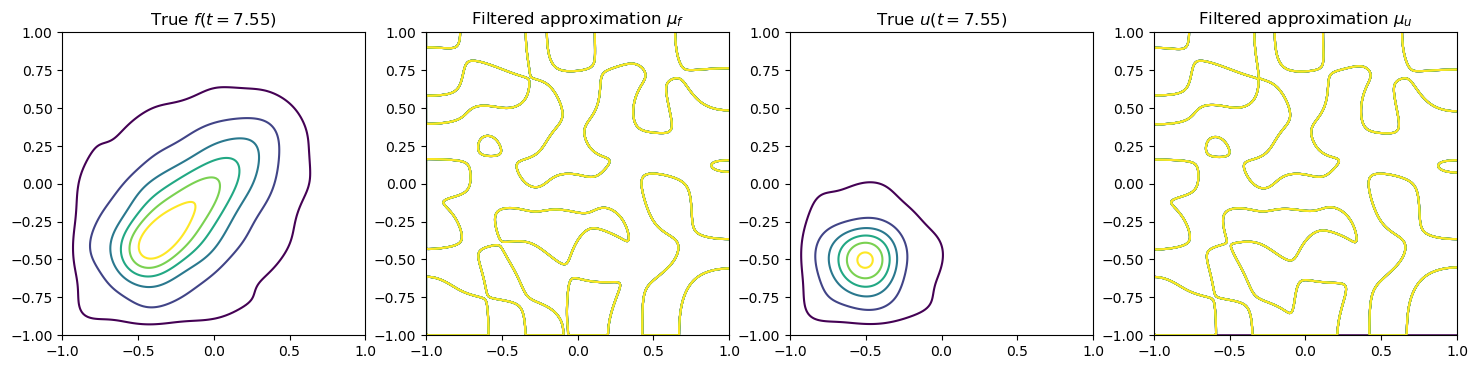

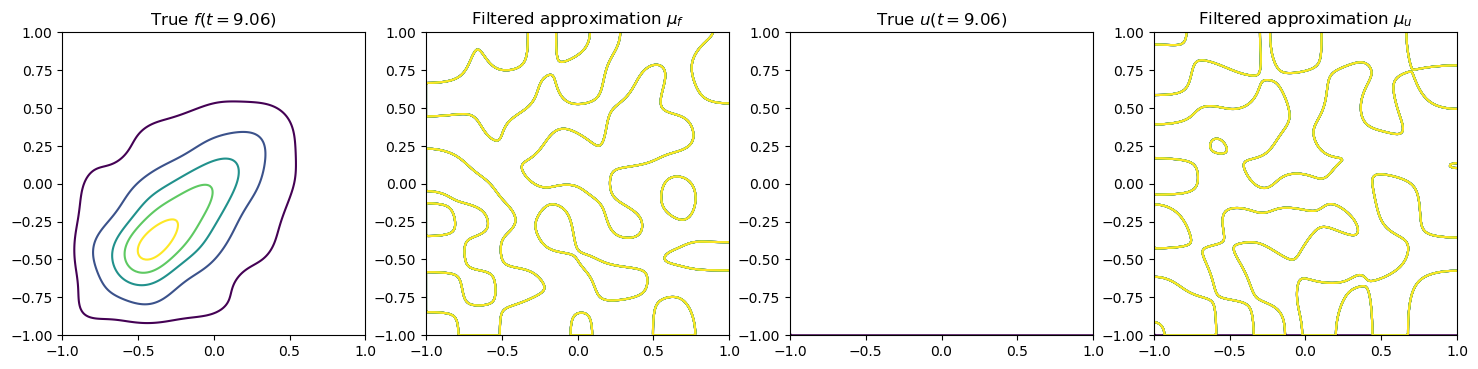

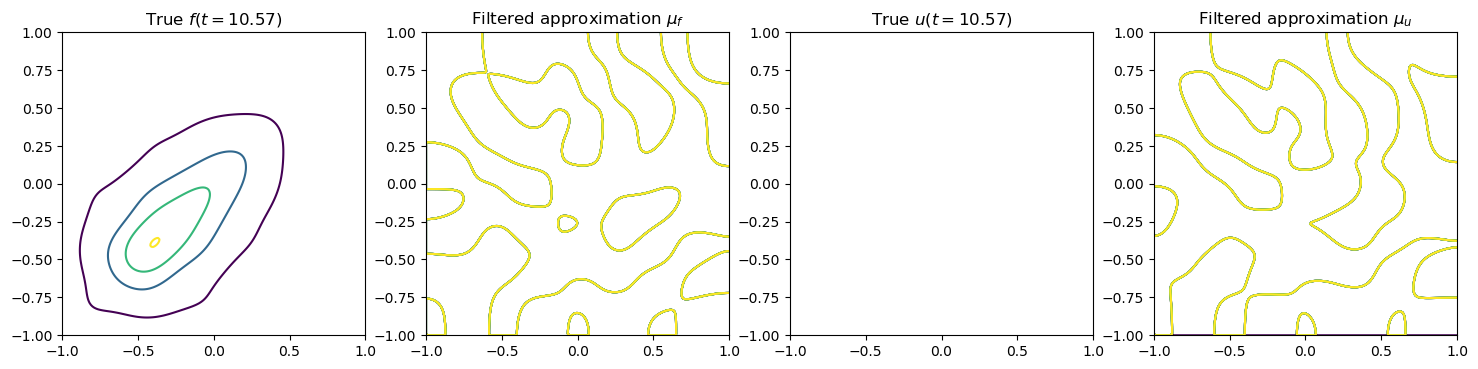

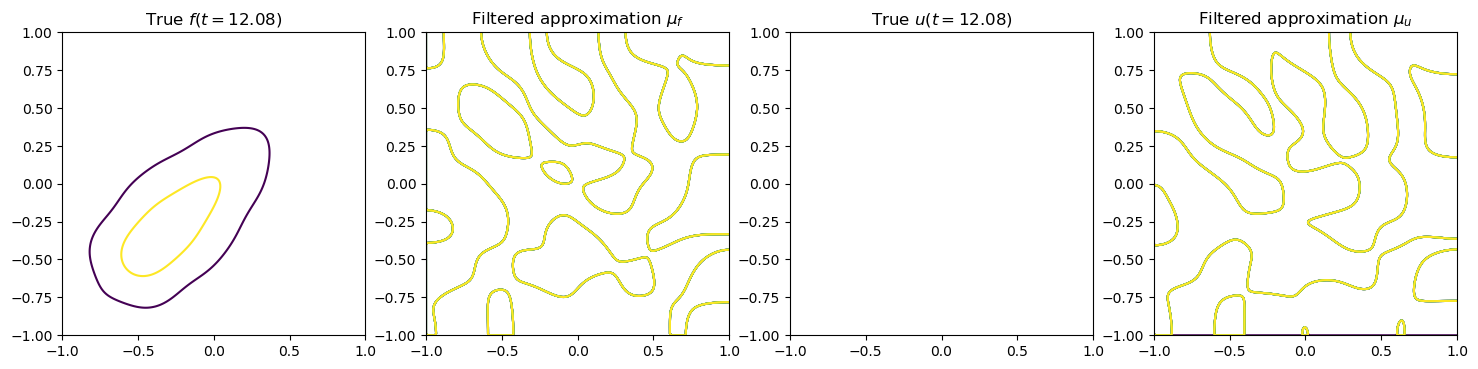

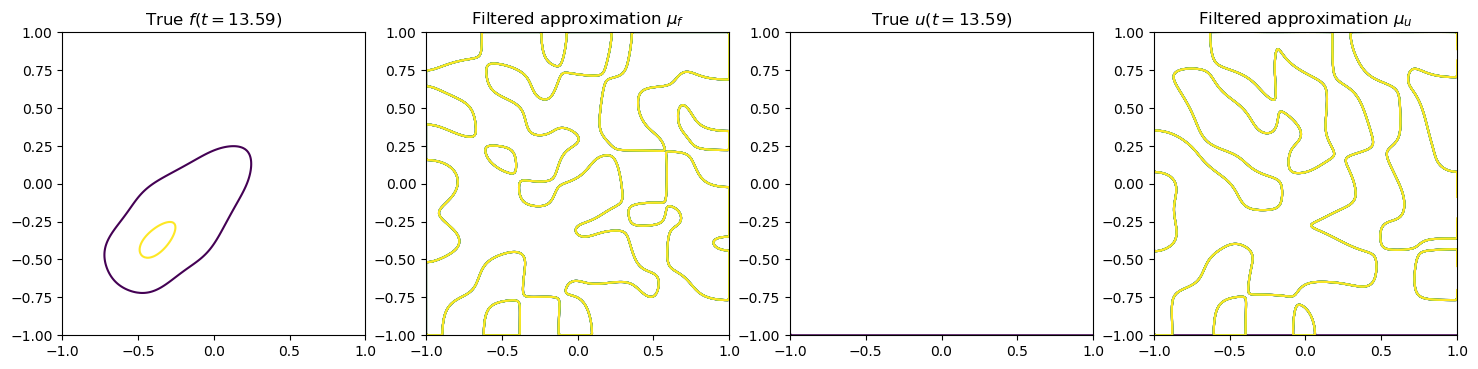

In [51]:
for k = 1:15:nₜ
    plotfilter(k, 𝛍ₓ[k], 𝛍ᵤ[k])
end

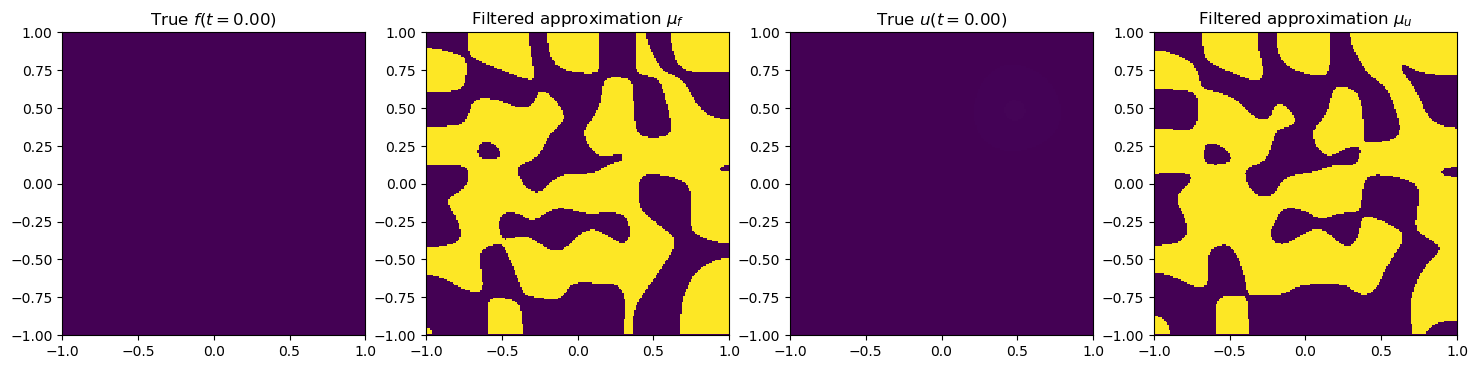

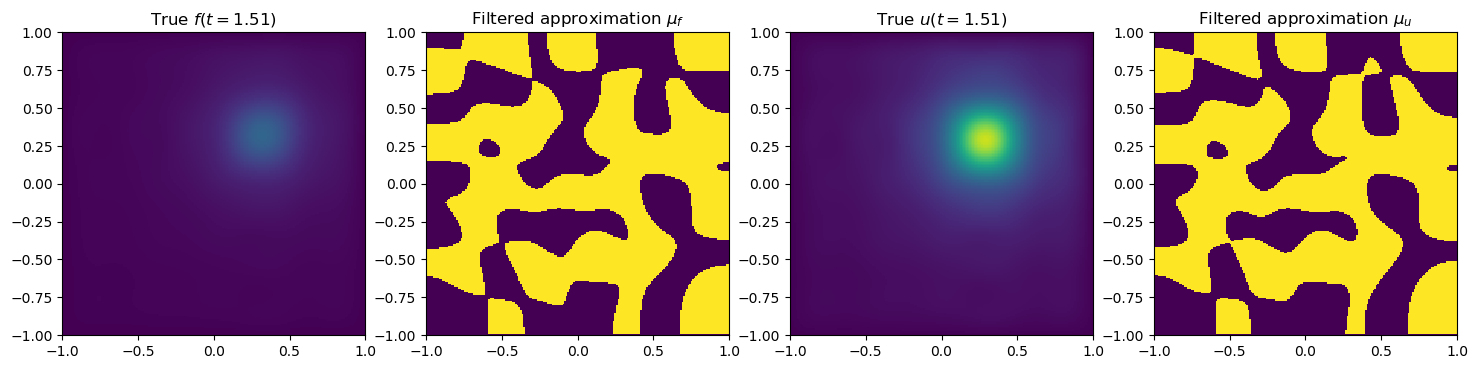

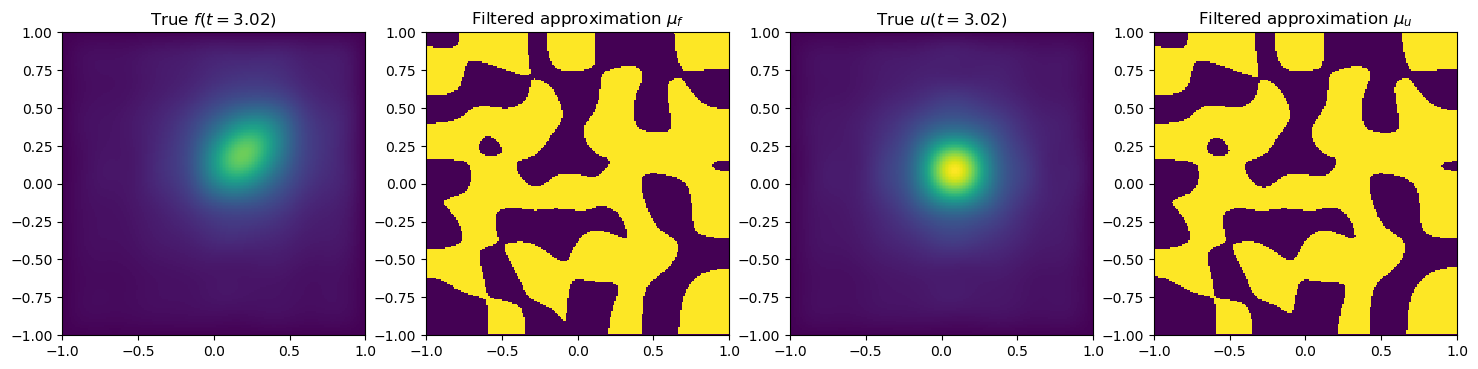

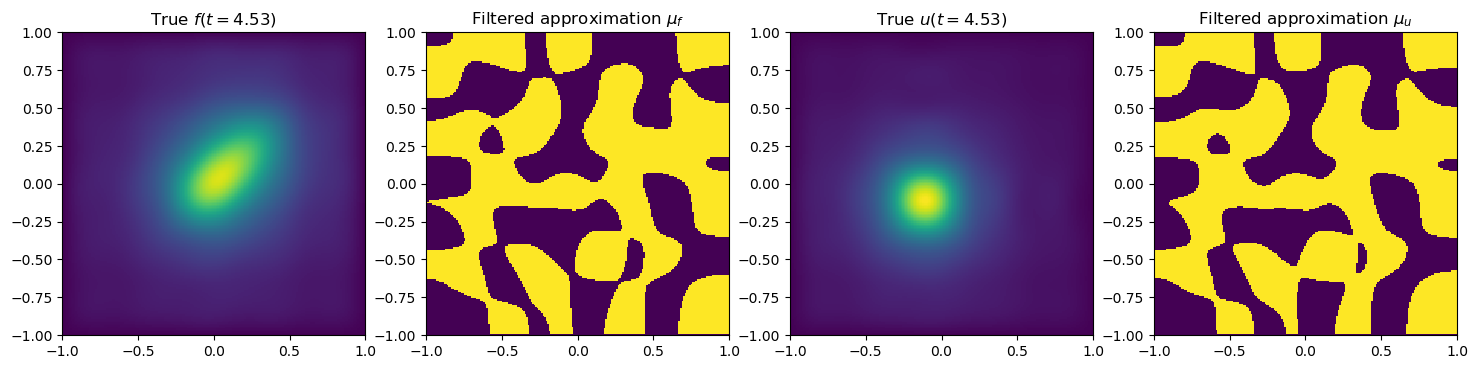

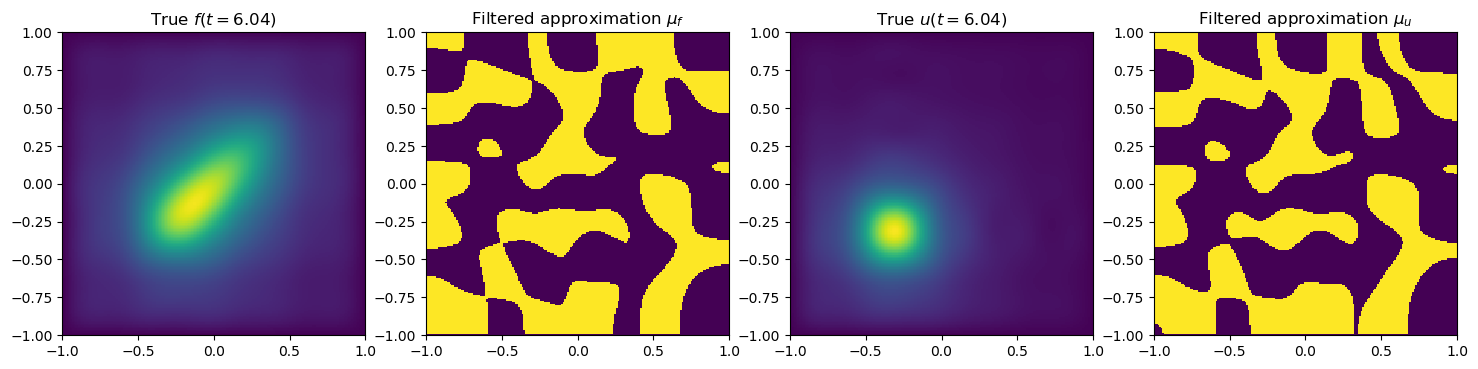

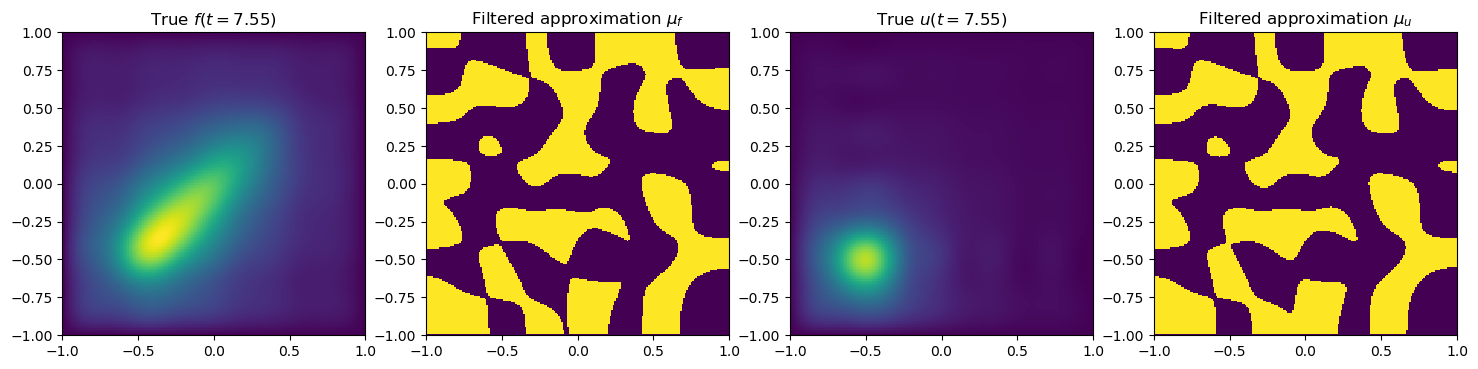

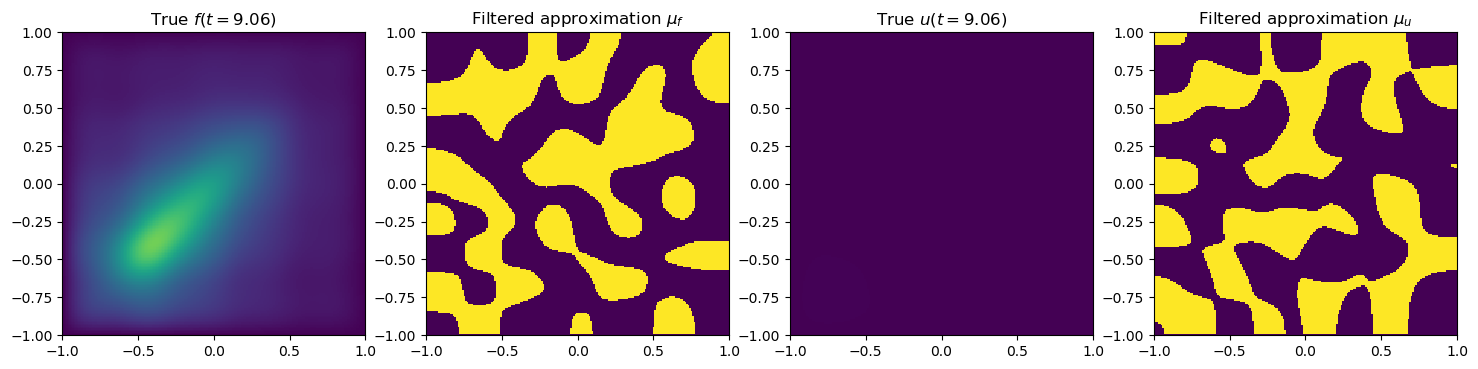

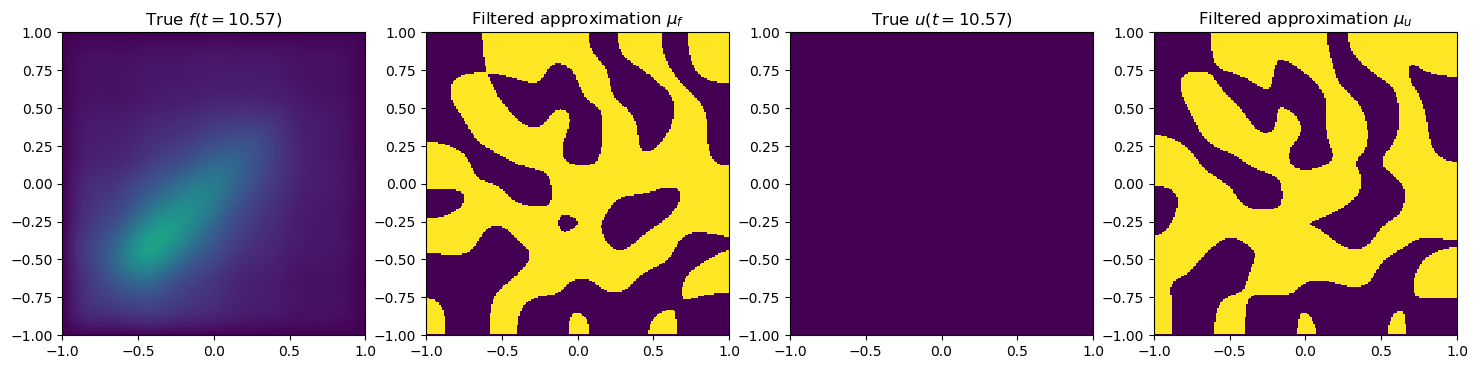

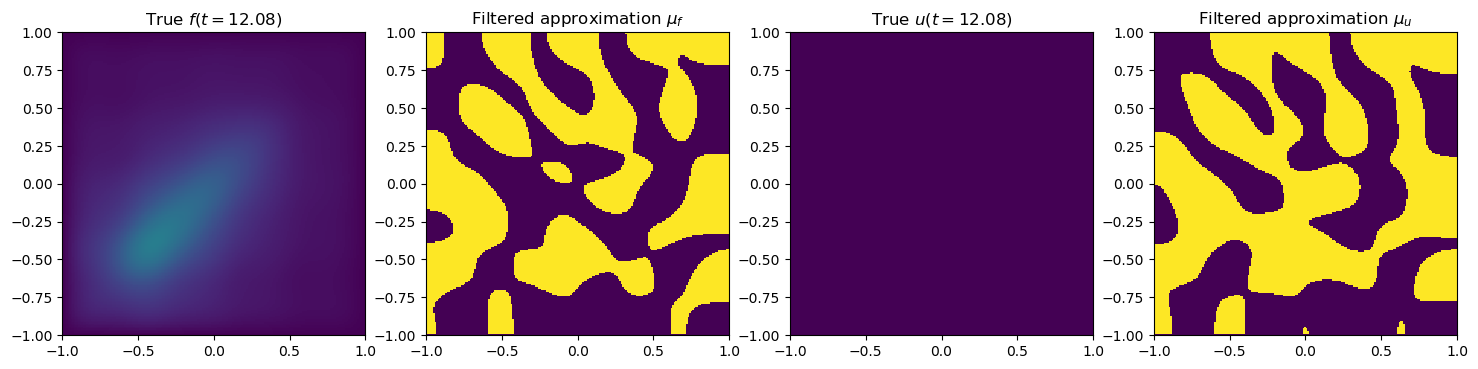

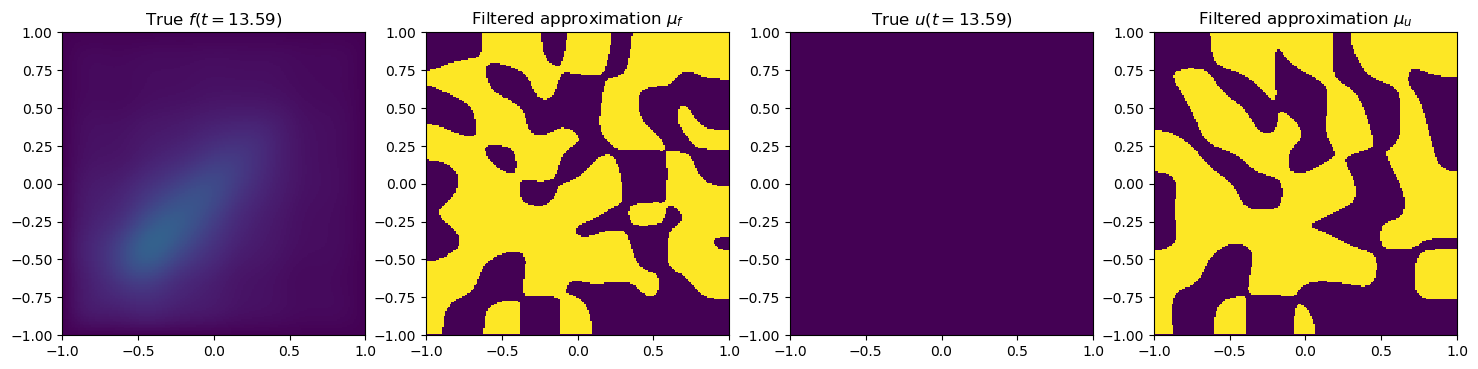

In [43]:
for k = 1:15:nₜ                                       
    colourfilter(k, 𝛍ₓ[k], 𝛍ᵤ[k])
end